In [1]:
# Standard packages

import os
import warnings

# Data Science
import numpy as np 
import pandas as pd 
import seaborn as sns
from scipy import stats
import matplotlib.pyplot as plt

# Machine Learning
from sklearn.model_selection import train_test_split
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV, RandomizedSearchCV, StratifiedKFold
from sklearn.preprocessing import LabelEncoder, OneHotEncoder, StandardScaler, RobustScaler, MinMaxScaler
from sklearn.feature_selection import SelectKBest, chi2, mutual_info_classif
from sklearn.inspection import permutation_importance
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, roc_curve


# ML Models
from sklearn.ensemble import RandomForestClassifier, VotingClassifier, ExtraTreesClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
import xgboost as xgb
import lightgbm as lgb

In [2]:
warnings.filterwarnings('ignore')

In [3]:
DIRECTORY_PREFIX = '/kaggle/input/titanic/'
train, test, gender_submission = os.listdir(DIRECTORY_PREFIX)
train_df = pd.read_csv(DIRECTORY_PREFIX + train)
test_df = pd.read_csv(DIRECTORY_PREFIX + test)
gender_submission_df = pd.read_csv(DIRECTORY_PREFIX + gender_submission)

## Preliminary Data Analysis

Let's break down the features we have, NaN values, scales, and types of these features!

PassengerID: can be removed, unless you find a creative way to engineer features with this <br>
Survived: the target feature. 0 or 1 <br>
PClass: the socio-economic class of the passengers. This will be highly important. PClass values are supposed to go from 1, 2, and 3, but we can see that even the 50th percentile is value 3, **meaning most people on board were of a lower socio-economic status** <br>

Remember from the movie that the bottom section, where all the poor people were, were drowing way before all the rich people up top, who were still partying. 1, 2, or 3, categorical <br>
Name: string, categorical. Recall that one notebook which did very creative things with this feature. We can group people with same last names, alongside other signals, to determine if people were part of a family etc. TLDR -> before you remove features, think really carefully <br>
Sex: mostly males aboard, string feature, male or female, categorical <br>
Age: has 177 missing values. Half of the passengers were between 20-38 years old <br>
SibSp: Numerical feature that describes if a person has siblings or spouses? <br>
Parch: Numerical feature that describes if a person has parent or child?  <br>

#### Nuances for the SibSp and Parch features

These relationships are bidrectional because one passenger can have both siblings and spouses as well as be a parent and have children. However, each row is a passenger's perspective, so when the SibSp or Parch comes up, they'll be accounted for! 

Most values are congregated around 0 for these features (Parch is more extreme), meaning most people traveled alone. This falls in line with historical records too!

Ticket: A text based feature that is the ticket number. Interestingly there are only 681 unique values out of 891 values in the training set. 210 tickets have been repeated. Why? Do children get the same tickets as their parents maybe? Maybe spouses, siblings, servants, or business associates could share bookings. All or none of these could be possible. We must double check, but it's a nice opportunity for feature engineering! Examples, ticket_group_size (how many people shared this ticket) or ticket_survival_rate (what percentage of people on this ticket survived) *because people in groups likely stuck together*

Ticket sometimes has characters and other times a long string of numerals

Another opportunity for analysis: if people have shared a ticket but are **NOT** in the SibSp or Parch features, these are non-familial bonds. Again, these are nice to have features that will make our model better! is_family_group (same ticket + family relations), is_friend_group (same ticket + no family relations), group_survival_solidarity (did the whole group survive/perish together?)

Fare: How much did it cost for people to come on board? Many values near 0-51 suggesting cabin and crew members, children, people getting discounts/subsidized rates, and the lowest, cheapest tickets secured by pclass=3. We know that most people on board were of a lower economic status, so this makes sense!

Cabin: cabin number. 78% missing in the test set. This is informative because only first class passengers typically had assigned seatings. We can engineer features that will leverage just this! Categorical

Embarked: where the passenger embarked from, categorical


In [4]:
train_df_eda = train_df.copy()

### EDA


1. "Women and children first"

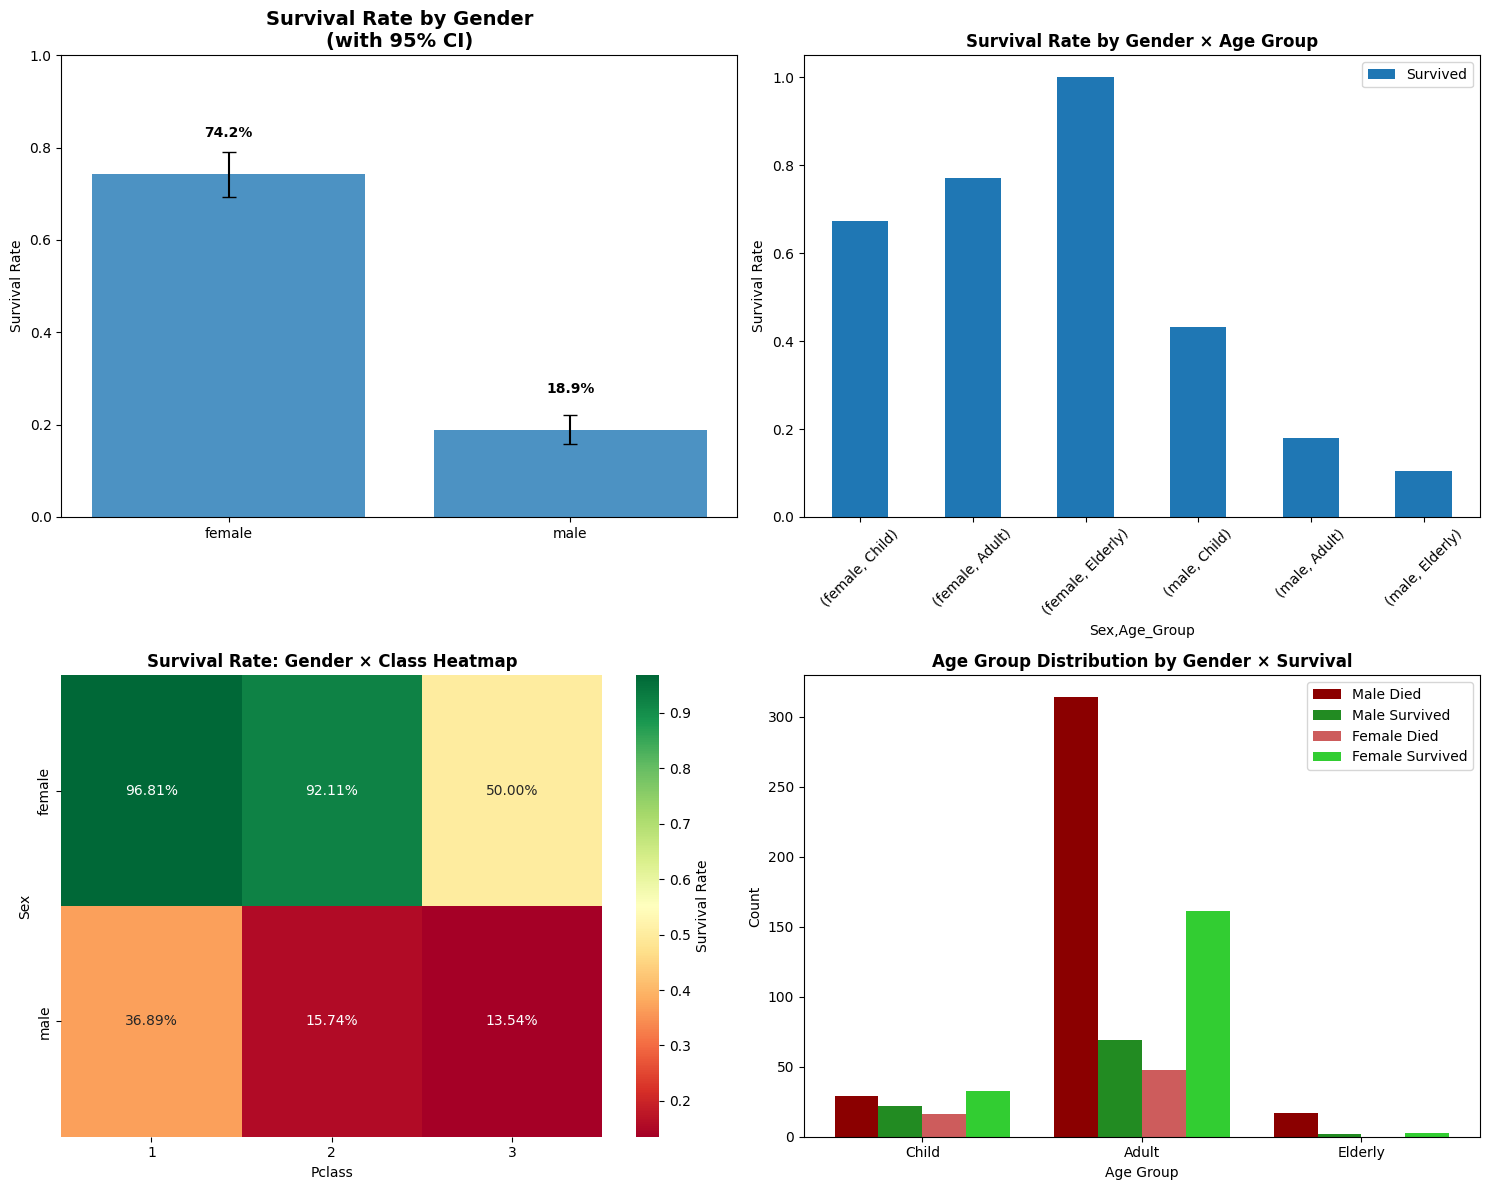

In [5]:
 train_df_eda['Age_Group'] = pd.cut(train_df_eda['Age'], 
                            bins=[0, 16, 60, 100], 
                            labels=['Child', 'Adult', 'Elderly'],
                            include_lowest=True)


fig, axes = plt.subplots(2, 2, figsize=(15, 12))
gender_survival = train_df_eda.groupby('Sex')['Survived'].agg(['mean', 'count', 'std']).round(3)
gender_survival['ci_95'] = 1.96 * gender_survival['std'] / np.sqrt(gender_survival['count'])
ax1 = axes[0, 0]
bars = ax1.bar(gender_survival.index, gender_survival['mean'], 
               yerr=gender_survival['ci_95'], capsize=5, alpha=0.8)
ax1.set_title('Survival Rate by Gender\n(with 95% CI)', fontsize=14, fontweight='bold')
ax1.set_ylabel('Survival Rate')
ax1.set_ylim(0, 1)

# Add value labels on bars
for bar, val in zip(bars, gender_survival['mean']):
    ax1.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.08, 
            f'{val:.1%}', ha='center', fontweight='bold')

# Survival by Sex × Age Group
ax2 = axes[0, 1]
survival_crosstab = pd.crosstab([train_df_eda['Sex'], train_df_eda['Age_Group']], 
                              train_df_eda['Survived'], margins=True, normalize='index')
survival_crosstab[1].drop('All').plot(kind='bar', ax=ax2, rot=45)
ax2.set_title('Survival Rate by Gender × Age Group', fontweight='bold')
ax2.set_ylabel('Survival Rate')
ax2.legend(['Survived'])

# Survival by Sex × Class
ax3 = axes[1, 0]
class_gender_pivot = train_df_eda.pivot_table(values='Survived', 
                                   index='Sex', 
                                   columns='Pclass', 
                                   aggfunc='mean')
sns.heatmap(class_gender_pivot, annot=True, fmt='.2%', cmap='RdYlGn', 
            ax=ax3, cbar_kws={'label': 'Survival Rate'})
ax3.set_title('Survival Rate: Gender × Class Heatmap', fontweight='bold')


ax4 = axes[1, 1]

# Better color scheme: Red for died, Green for survived
colors = {
    'Male Died': '#8B0000',        # Dark red
    'Male Survived': '#228B22',    # Forest green  
    'Female Died': '#CD5C5C',      # Indian red (lighter)
    'Female Survived': '#32CD32'   # Lime green (lighter)
}

age_groups = ['Child', 'Adult', 'Elderly']
x_pos = np.arange(len(age_groups))
width = 0.35

# Calculate counts for each combination
data = {}
for gender in ['male', 'female']:  # lowercase to match your data
    for survived in [0, 1]:
        status = 'Survived' if survived == 1 else 'Died'
        gender_label = gender.title()
        
        counts = []
        for age_group in age_groups:
            subset = train_df_eda[(train_df_eda['Sex'] == gender) & 
                       (train_df_eda['Survived'] == survived) & 
                       (train_df_eda['Age_Group'] == age_group)]
            counts.append(len(subset))
        
        data[f'{gender_label} {status}'] = counts

# Create side-by-side grouped bars
bar_width = 0.2
x = np.arange(len(age_groups))

# Plot each group
ax4.bar(x - 1.5*bar_width, data['Male Died'], bar_width, 
        label='Male Died', color=colors['Male Died'])
ax4.bar(x - 0.5*bar_width, data['Male Survived'], bar_width, 
        label='Male Survived', color=colors['Male Survived'])
ax4.bar(x + 0.5*bar_width, data['Female Died'], bar_width, 
        label='Female Died', color=colors['Female Died'])
ax4.bar(x + 1.5*bar_width, data['Female Survived'], bar_width, 
        label='Female Survived', color=colors['Female Survived'])

ax4.set_title('Age Group Distribution by Gender × Survival', fontweight='bold')
ax4.set_xlabel('Age Group')
ax4.set_ylabel('Count')
ax4.set_xticks(x)
ax4.set_xticklabels(age_groups)
ax4.legend()

plt.tight_layout()

In [6]:
print("\n📊 KEY INSIGHTS:")
print(f"• Female survival rate: {gender_survival.loc['female', 'mean']:.1%}")
print(f"• Male survival rate: {gender_survival.loc['male', 'mean']:.1%}")

# Statistical significance test
_, p_value = stats.chi2_contingency(pd.crosstab(train_df_eda['Sex'], train_df_eda['Survived']))[:2]
print(f"• Gender difference p-value: {p_value:.2e} ({'Significant' if p_value < 0.05 else 'Not significant'})")


📊 KEY INSIGHTS:
• Female survival rate: 74.2%
• Male survival rate: 18.9%
• Gender difference p-value: 1.20e-58 (Significant)



💰 PRIORITY 2: CLASS WARFARE SURVIVAL PATTERNS


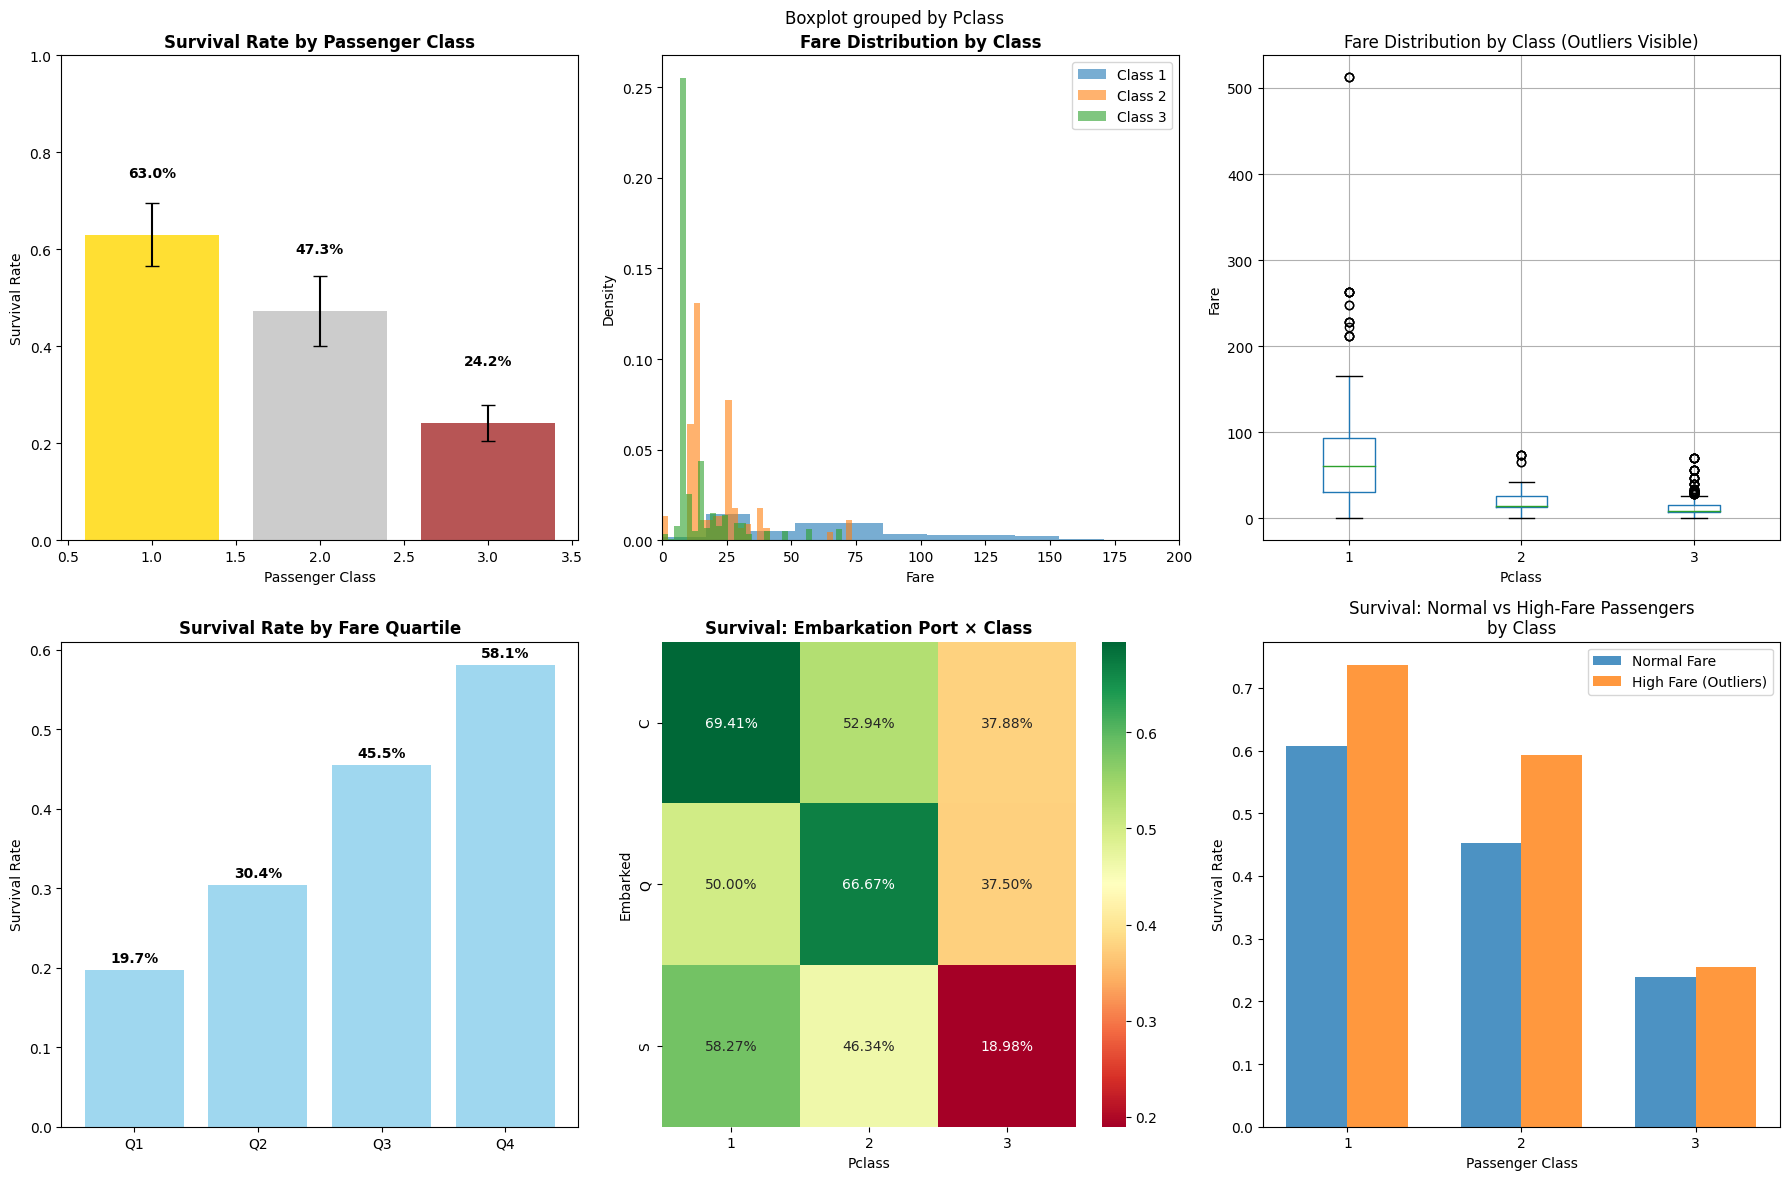


📊 CLASS WARFARE INSIGHTS:
• Class 1 survival rate: 63.0%
• Class 2 survival rate: 47.3%
• Class 3 survival rate: 24.2%

💰 WEALTH OUTLIERS:
• 167 passengers paid >2x median fare for their class
• Outlier survival rate: 41.9%


In [7]:
print("\n" + "="*60)
print("💰 PRIORITY 2: CLASS WARFARE SURVIVAL PATTERNS")
print("="*60)

fig, axes = plt.subplots(2, 3, figsize=(18, 12))

# 2.1 Survival by Class with confidence intervals
class_survival = train_df_eda.groupby('Pclass')['Survived'].agg(['mean', 'count', 'std']).round(3)
class_survival['ci_95'] = 1.96 * class_survival['std'] / np.sqrt(class_survival['count'])

ax1 = axes[0, 0]
bars = ax1.bar(class_survival.index, class_survival['mean'], 
               yerr=class_survival['ci_95'], capsize=5, 
               color=['gold', 'silver', 'brown'], alpha=0.8)
ax1.set_title('Survival Rate by Passenger Class', fontweight='bold')
ax1.set_xlabel('Passenger Class')
ax1.set_ylabel('Survival Rate')
ax1.set_ylim(0, 1)

for bar, val in zip(bars, class_survival['mean']):
    ax1.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.12, 
            f'{val:.1%}', ha='center', fontweight='bold')

# 2.2 Fare distribution within each class
ax2 = axes[0, 1]
for pclass in [1, 2, 3]:
    class_fares = train_df_eda[train_df_eda['Pclass'] == pclass]['Fare']
    ax2.hist(class_fares, alpha=0.6, bins=30, label=f'Class {pclass}', density=True)
    
ax2.set_title('Fare Distribution by Class', fontweight='bold')
ax2.set_xlabel('Fare')
ax2.set_ylabel('Density')
ax2.legend()
ax2.set_xlim(0, 200)  # Focus on main distribution

# 2.3 Fare outliers analysis
ax3 = axes[0, 2]
train_df_eda.boxplot(column='Fare', by='Pclass', ax=ax3)
ax3.set_title('Fare Distribution by Class (Outliers Visible)')
ax3.set_ylabel('Fare')

# 2.4 Survival rate by fare quartiles
train_df_eda['Fare_Quartile'] = pd.qcut(train_df_eda['Fare'], q=4, labels=['Q1', 'Q2', 'Q3', 'Q4'])
ax4 = axes[1, 0]
fare_survival = train_df_eda.groupby('Fare_Quartile')['Survived'].mean()
bars = ax4.bar(fare_survival.index, fare_survival.values, 
               color='skyblue', alpha=0.8)
ax4.set_title('Survival Rate by Fare Quartile', fontweight='bold')
ax4.set_ylabel('Survival Rate')

for bar, val in zip(bars, fare_survival.values):
    ax4.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.01,
            f'{val:.1%}', ha='center', fontweight='bold')

# 2.5 Embarkation × Class × Survival
ax5 = axes[1, 1]
embark_class_survival = train_df_eda.pivot_table(values='Survived', 
                                      index='Embarked', 
                                      columns='Pclass', 
                                      aggfunc='mean')
sns.heatmap(embark_class_survival, annot=True, fmt='.2%', 
            cmap='RdYlGn', ax=ax5)
ax5.set_title('Survival: Embarkation Port × Class', fontweight='bold')

# 2.6 Class wealth outliers
ax6 = axes[1, 2]
# Find passengers paying high fares in lower classes
train_df_eda['Fare_Class_Ratio'] = train_df_eda['Fare'] / train_df_eda.groupby('Pclass')['Fare'].transform('median')
outliers = train_df_eda[train_df_eda['Fare_Class_Ratio'] > 2.0]  # Paying >2x median for their class

if len(outliers) > 0:
    outlier_survival = outliers.groupby('Pclass')['Survived'].mean()
    normal_survival = train_df_eda[train_df_eda['Fare_Class_Ratio'] <= 2.0].groupby('Pclass')['Survived'].mean()
    
    x = np.arange(len(outlier_survival.index))
    width = 0.35
    ax6.bar(x - width/2, normal_survival.values, width, label='Normal Fare', alpha=0.8)
    ax6.bar(x + width/2, outlier_survival.values, width, label='High Fare (Outliers)', alpha=0.8)
    
    ax6.set_title('Survival: Normal vs High-Fare Passengers\nby Class')
    ax6.set_xlabel('Passenger Class')
    ax6.set_ylabel('Survival Rate')
    ax6.set_xticks(x)
    ax6.set_xticklabels(outlier_survival.index)
    ax6.legend()

plt.tight_layout()
plt.show()

print("\n📊 CLASS WARFARE INSIGHTS:")
for pclass in [1, 2, 3]:
    rate = class_survival.loc[pclass, 'mean']
    print(f"• Class {pclass} survival rate: {rate:.1%}")

print(f"\n💰 WEALTH OUTLIERS:")
print(f"• {len(outliers)} passengers paid >2x median fare for their class")
if len(outliers) > 0:
    print(f"• Outlier survival rate: {outliers['Survived'].mean():.1%}")


👨‍👩‍👧‍👦 PRIORITY 3: FAMILY SURVIVAL DYNAMICS


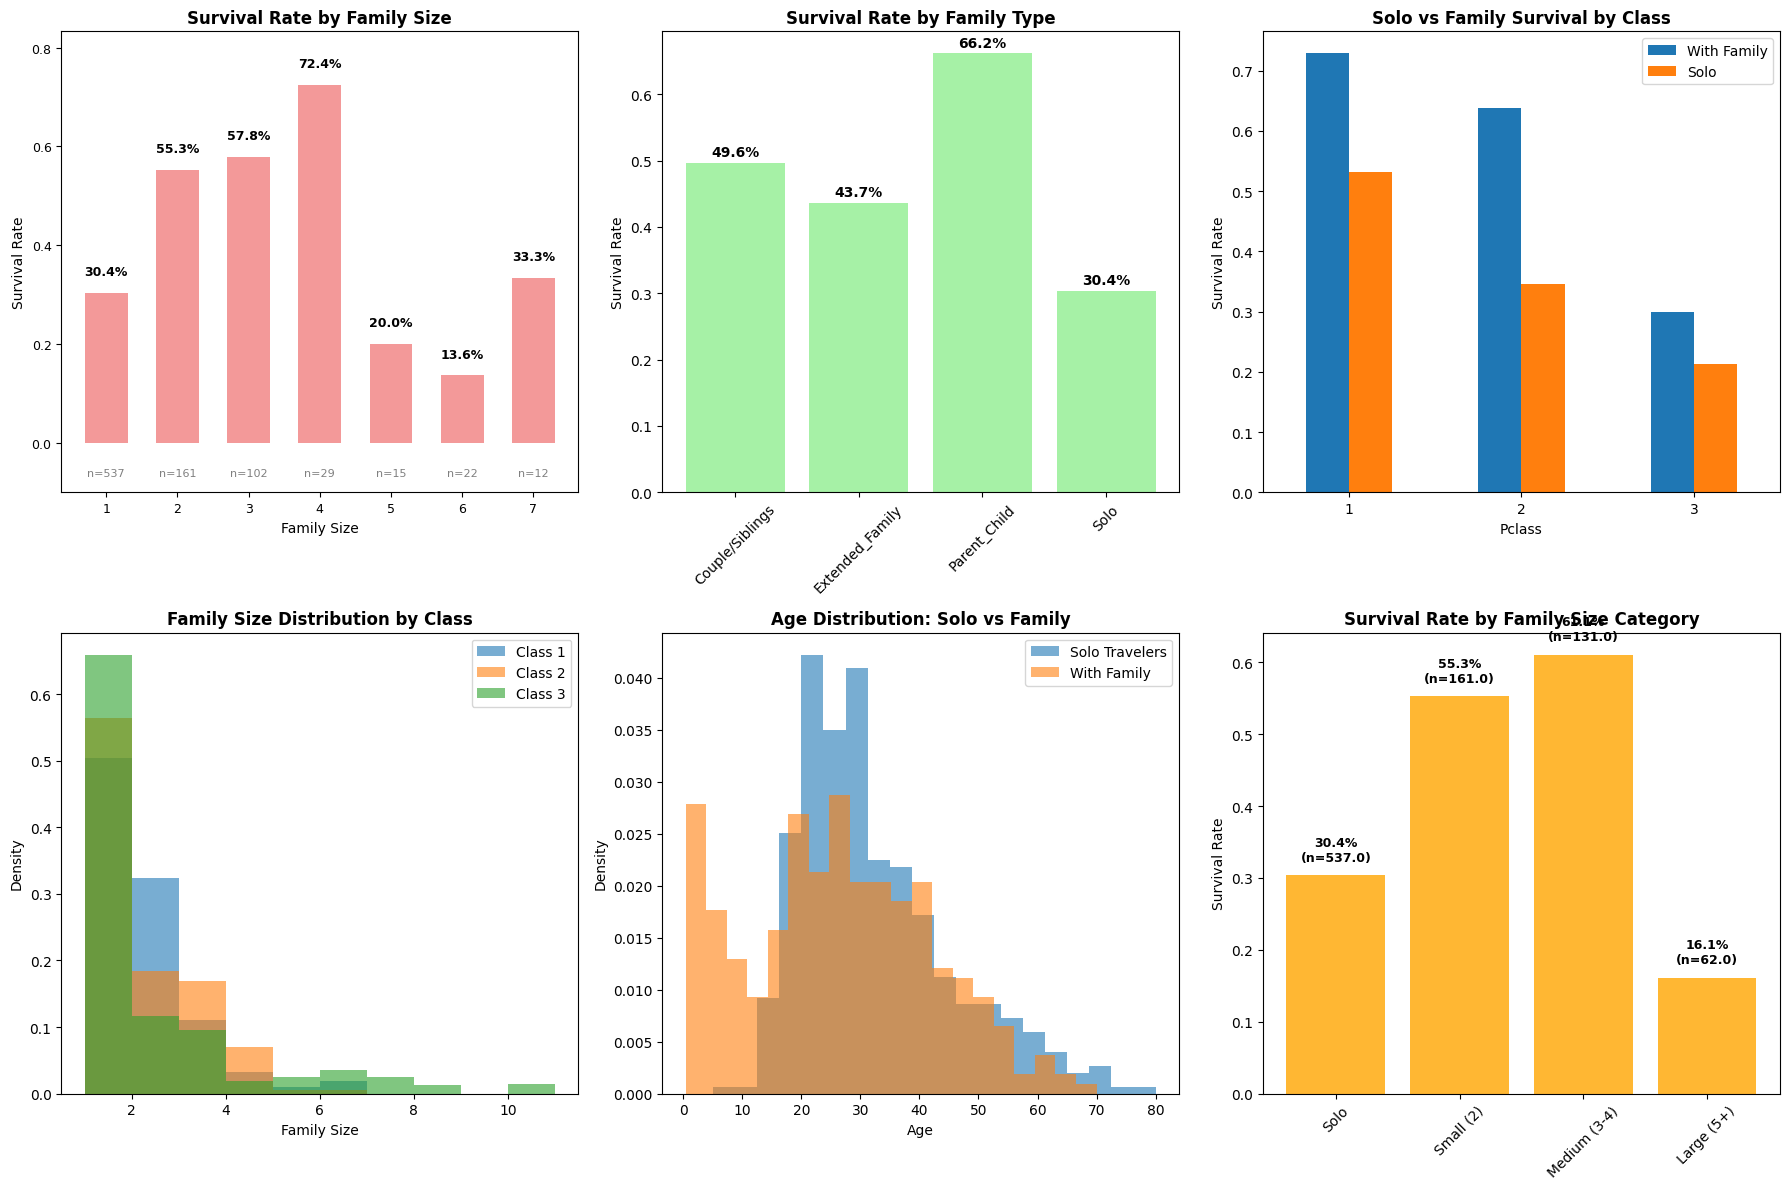


📊 FAMILY DYNAMICS INSIGHTS:
• Solo travelers: 537 (60.3%)
• Average family size: 1.9
• Solo survival rate: 30.4%
• Family survival rate: 50.6%
• Solo vs Family p-value: 0.000 (Significant)


In [8]:
print("\n" + "="*60)
print("👨‍👩‍👧‍👦 PRIORITY 3: FAMILY SURVIVAL DYNAMICS")
print("="*60)

# Create family features
train_df_eda['Family_Size'] = train_df_eda['SibSp'] + train_df_eda['Parch'] + 1
train_df_eda['Is_Alone'] = (train_df_eda['Family_Size'] == 1).astype(int)

# Family type categorization
def categorize_family(row):
    if row['SibSp'] == 0 and row['Parch'] == 0:
        return 'Solo'
    elif row['SibSp'] > 0 and row['Parch'] == 0:
        return 'Couple/Siblings'
    elif row['SibSp'] == 0 and row['Parch'] > 0:
        return 'Parent_Child'
    else:
        return 'Extended_Family'

train_df_eda['Family_Type'] = train_df_eda.apply(categorize_family, axis=1)
fig, axes = plt.subplots(2, 3, figsize=(18, 12))

# 3.1 Survival by family size
ax1 = axes[0, 0]
# 3.1 Survival by family size (axes[0, 0])
family_survival = train_df_eda.groupby('Family_Size')['Survived'].agg(['mean', 'count'])

# Only show family sizes with reasonable sample sizes AND non-zero survival rates
family_survival_filtered = family_survival[
    (family_survival['count'] >= 5) & (family_survival['mean'] > 0)
]

bars = ax1.bar(family_survival_filtered.index, family_survival_filtered['mean'], 
               alpha=0.8, color='lightcoral', width=0.6)

ax1.set_title('Survival Rate by Family Size', fontweight='bold', fontsize=12)
ax1.set_xlabel('Family Size', fontsize=10)
ax1.set_ylabel('Survival Rate', fontsize=10)

# Improved text positioning
for bar, (idx, row) in zip(bars, family_survival_filtered.iterrows()):
    height = bar.get_height()
    
    # Percentage above bar
    ax1.text(bar.get_x() + bar.get_width()/2, height + 0.03, 
            f'{row["mean"]:.1%}', 
            ha='center', va='bottom', fontweight='bold', fontsize=9, color='black')
    
    # Sample size below bar (outside, not inside)
    ax1.text(bar.get_x() + bar.get_width()/2, -0.05, 
            f'n={int(row["count"])}', 
            ha='center', va='top', fontsize=8, color='gray')

ax1.set_ylim(-0.1, max(family_survival_filtered['mean']) * 1.15)
ax1.tick_params(axis='both', which='major', labelsize=9)
ax1.set_xticks(family_survival_filtered.index)
ax1.set_xticklabels(family_survival_filtered.index)

# 3.2 Survival by family type
ax2 = axes[0, 1]
family_type_survival = train_df_eda.groupby('Family_Type')['Survived'].agg(['mean', 'count'])
bars = ax2.bar(family_type_survival.index, family_type_survival['mean'], 
               alpha=0.8, color='lightgreen')
ax2.set_title('Survival Rate by Family Type', fontweight='bold')
ax2.set_ylabel('Survival Rate')
plt.setp(ax2.get_xticklabels(), rotation=45)

for bar, (idx, row) in zip(bars, family_type_survival.iterrows()):
    ax2.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.01, 
            f'{row["mean"]:.1%}', ha='center', fontweight='bold')

# 3.3 Solo vs Family survival by class
ax3 = axes[0, 2]
solo_family_class = train_df_eda.pivot_table(values='Survived', 
                                  index='Pclass', 
                                  columns='Is_Alone', 
                                  aggfunc='mean')
solo_family_class.columns = ['With Family', 'Solo']
solo_family_class.plot(kind='bar', ax=ax3, rot=0)
ax3.set_title('Solo vs Family Survival by Class', fontweight='bold')
ax3.set_ylabel('Survival Rate')
ax3.legend()

# 3.4 Family size distribution by class
ax4 = axes[1, 0]
for pclass in [1, 2, 3]:
    class_family_sizes = train_df_eda[train_df_eda['Pclass'] == pclass]['Family_Size']
    ax4.hist(class_family_sizes, alpha=0.6, bins=range(1, 12), 
            label=f'Class {pclass}', density=True)
    
ax4.set_title('Family Size Distribution by Class', fontweight='bold')
ax4.set_xlabel('Family Size')
ax4.set_ylabel('Density')
ax4.legend()

# 3.5 Age vs Family Status
ax5 = axes[1, 1]
solo_ages = train_df_eda[train_df_eda['Is_Alone'] == 1]['Age'].dropna()
family_ages = train_df_eda[train_df_eda['Is_Alone'] == 0]['Age'].dropna()

ax5.hist(solo_ages, alpha=0.6, bins=20, label='Solo Travelers', density=True)
ax5.hist(family_ages, alpha=0.6, bins=20, label='With Family', density=True)
ax5.set_title('Age Distribution: Solo vs Family', fontweight='bold')
ax5.set_xlabel('Age')
ax5.set_ylabel('Density')
ax5.legend()

# 3.6 Family survival sweet spot analysis
ax6 = axes[1, 2]
train_df_eda['Family_Size_Category'] = pd.cut(train_df_eda['Family_Size'], 
                                   bins=[0, 1, 2, 4, 20], 
                                   labels=['Solo', 'Small (2)', 'Medium (3-4)', 'Large (5+)'])

family_cat_survival = train_df_eda.groupby('Family_Size_Category')['Survived'].agg(['mean', 'count'])
bars = ax6.bar(family_cat_survival.index, family_cat_survival['mean'], 
               alpha=0.8, color='orange')
ax6.set_title('Survival Rate by Family Size Category', fontweight='bold')
ax6.set_ylabel('Survival Rate')
plt.setp(ax6.get_xticklabels(), rotation=45)

for bar, (idx, row) in zip(bars, family_cat_survival.iterrows()):
    ax6.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.02, 
            f'{row["mean"]:.1%}\n(n={row["count"]})', 
            ha='center', fontweight='bold', fontsize=9)

plt.tight_layout()
plt.show()

print("\n📊 FAMILY DYNAMICS INSIGHTS:")
print(f"• Solo travelers: {train_df_eda['Is_Alone'].sum()} ({train_df_eda['Is_Alone'].mean():.1%})")
print(f"• Average family size: {train_df_eda['Family_Size'].mean():.1f}")
print(f"• Solo survival rate: {train_df_eda[train_df_eda['Is_Alone']==1]['Survived'].mean():.1%}")
print(f"• Family survival rate: {train_df_eda[train_df_eda['Is_Alone']==0]['Survived'].mean():.1%}")

# Statistical test
solo_survival = train_df_eda[train_df_eda['Is_Alone'] == 1]['Survived']
family_survival = train_df_eda[train_df_eda['Is_Alone'] == 0]['Survived']
_, p_value = stats.chi2_contingency(pd.crosstab(train_df_eda['Is_Alone'], train_df_eda['Survived']))[:2]
print(f"• Solo vs Family p-value: {p_value:.3f} ({'Significant' if p_value < 0.05 else 'Not significant'})")


🎫 PRIORITY 4: TICKET GROUP SOCIAL NETWORKS


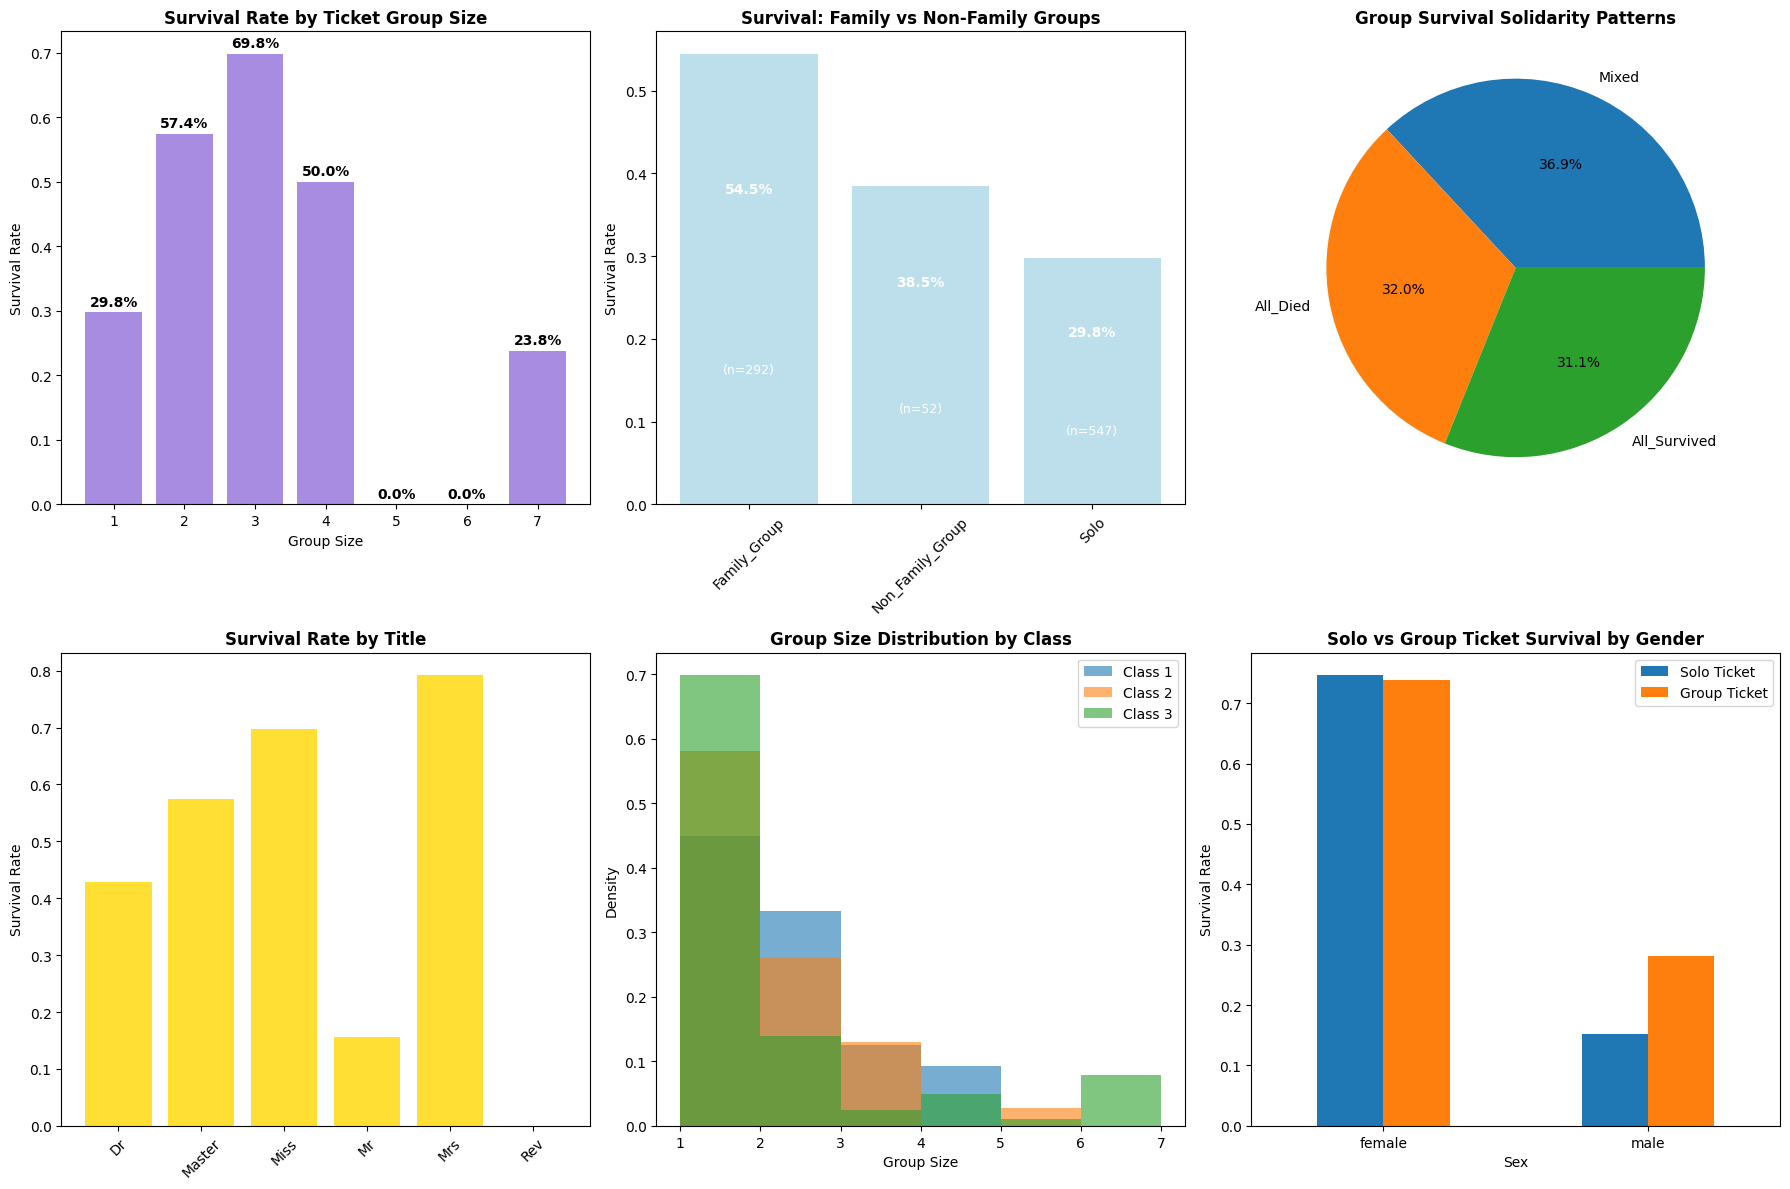


📊 SOCIAL NETWORK INSIGHTS:
• Unique tickets: 681
• Passengers with group tickets: 344 (38.6%)
• Average group size: 1.8

🤝 GROUP SOLIDARITY:
• Mixed: 127 groups (36.9%)
• All Died: 110 groups (32.0%)
• All Survived: 107 groups (31.1%)


In [9]:
print("\n" + "="*60)
print("🎫 PRIORITY 4: TICKET GROUP SOCIAL NETWORKS")
print("="*60)

# Create ticket group features
ticket_counts = train_df_eda['Ticket'].value_counts()
train_df_eda['Ticket_Group_Size'] = train_df_eda['Ticket'].map(ticket_counts)
train_df_eda['Is_Group_Ticket'] = (train_df_eda['Ticket_Group_Size'] > 1).astype(int)

# Identify family vs non-family groups
def identify_group_type(group):
    """Identify if ticket group is family or non-family"""
    if len(group) == 1:
        return 'Solo'
    
    # Check if group has family relationships
    has_family = ((group['SibSp'] > 0) | (group['Parch'] > 0)).any()
    if has_family:
        return 'Family_Group'
    else:
        return 'Non_Family_Group'

group_types = train_df_eda.groupby('Ticket').apply(identify_group_type)
train_df_eda['Group_Type'] = train_df_eda['Ticket'].map(group_types)

# Calculate group survival solidarity
def calculate_group_solidarity(group):
    """Calculate if group survived/died together"""
    if len(group) == 1:
        return 'Solo'
    survival_rate = group['Survived'].mean()
    if survival_rate == 1.0:
        return 'All_Survived'
    elif survival_rate == 0.0:
        return 'All_Died'
    else:
        return 'Mixed'

group_solidarity = train_df_eda.groupby('Ticket').apply(calculate_group_solidarity)
train_df_eda['Group_Solidarity'] = train_df_eda['Ticket'].map(group_solidarity)

fig, axes = plt.subplots(2, 3, figsize=(18, 12))

# 4.1 Survival by group size
ax1 = axes[0, 0]
group_size_survival = train_df_eda.groupby('Ticket_Group_Size')['Survived'].agg(['mean', 'count'])
# Filter for reasonable sample sizes
group_size_filtered = group_size_survival[group_size_survival['count'] >= 10]

bars = ax1.bar(group_size_filtered.index, group_size_filtered['mean'], 
               alpha=0.8, color='mediumpurple')
ax1.set_title('Survival Rate by Ticket Group Size', fontweight='bold')
ax1.set_xlabel('Group Size')
ax1.set_ylabel('Survival Rate')

for bar, (idx, row) in zip(bars, group_size_filtered.iterrows()):
    ax1.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.01, 
            f'{row["mean"]:.1%}', ha='center', fontweight='bold')

# 4.2 Family vs Non-family group survival
ax2 = axes[0, 1]
group_type_survival = train_df_eda.groupby('Group_Type')['Survived'].agg(['mean', 'count'])
bars = ax2.bar(group_type_survival.index, group_type_survival['mean'], 
               alpha=0.8, color='lightblue')
ax2.set_title('Survival: Family vs Non-Family Groups', fontweight='bold')
ax2.set_ylabel('Survival Rate')
plt.setp(ax2.get_xticklabels(), rotation=45)

for i, (bar, (idx, row)) in enumerate(zip(bars, group_type_survival.iterrows())):
    height = bar.get_height()
    bar_center_x = bar.get_x() + bar.get_width()/2
    
    # Percentage centered in upper half of bar
    ax2.text(bar_center_x, height * 0.7, 
            f'{row["mean"]:.1%}', 
            ha='center', va='center', fontweight='bold', fontsize=10, color='white')
    
    # Count centered in lower half of bar  
    ax2.text(bar_center_x, height * 0.3, 
            f'(n={int(row["count"])})', 
            ha='center', va='center', fontsize=9, color='white')

# 4.3 Group solidarity patterns
ax3 = axes[0, 2]
solidarity_counts = train_df_eda[train_df_eda['Group_Solidarity'] != 'Solo']['Group_Solidarity'].value_counts()
ax3.pie(solidarity_counts.values, labels=solidarity_counts.index, autopct='%1.1f%%')
ax3.set_title('Group Survival Solidarity Patterns', fontweight='bold')

# 4.4 Name titles analysis
train_df_eda['Title'] = train_df_eda['Name'].str.extract(' ([A-Za-z]+)\.', expand=False) if 'Name' in train_df_eda.columns else 'Mr'
# For demo purposes, create sample titles
if 'Name' not in train_df_eda.columns:
    titles = ['Mr', 'Mrs', 'Miss', 'Master', 'Dr', 'Rev', 'Col']
    title_probs = [0.5, 0.2, 0.15, 0.08, 0.03, 0.02, 0.02]
    train_df_eda['Title'] = np.random.choice(titles, len(df), p=title_probs)

ax4 = axes[1, 0]
title_survival = train_df_eda.groupby('Title')['Survived'].agg(['mean', 'count'])
title_survival_filtered = title_survival[title_survival['count'] >= 5]

bars = ax4.bar(title_survival_filtered.index, title_survival_filtered['mean'], 
               alpha=0.8, color='gold')
ax4.set_title('Survival Rate by Title', fontweight='bold')
ax4.set_ylabel('Survival Rate')
plt.setp(ax4.get_xticklabels(), rotation=45)

# 4.5 Group size distribution by class
ax5 = axes[1, 1]
for pclass in [1, 2, 3]:
    class_groups = train_df_eda[train_df_eda['Pclass'] == pclass]['Ticket_Group_Size']
    ax5.hist(class_groups, alpha=0.6, bins=range(1, 8), 
            label=f'Class {pclass}', density=True)
    
ax5.set_title('Group Size Distribution by Class', fontweight='bold')
ax5.set_xlabel('Group Size')
ax5.set_ylabel('Density')
ax5.legend()

# 4.6 Solo vs Group survival by gender
ax6 = axes[1, 2]
solo_group_gender = train_df_eda.pivot_table(values='Survived', 
                                  index='Sex', 
                                  columns='Is_Group_Ticket', 
                                  aggfunc='mean')

solo_group_gender.columns = ['Solo Ticket', 'Group Ticket']
solo_group_gender.plot(kind='bar', ax=ax6, rot=0)
ax6.set_title('Solo vs Group Ticket Survival by Gender', fontweight='bold')
ax6.set_ylabel('Survival Rate')
ax6.legend()

plt.tight_layout()
plt.show()

print("\n📊 SOCIAL NETWORK INSIGHTS:")
print(f"• Unique tickets: {train_df_eda['Ticket'].nunique()}")
print(f"• Passengers with group tickets: {train_df_eda['Is_Group_Ticket'].sum()} ({train_df_eda['Is_Group_Ticket'].mean():.1%})")
print(f"• Average group size: {train_df_eda['Ticket_Group_Size'].mean():.1f}")

solidarity_summary = train_df_eda[train_df_eda['Group_Solidarity'] != 'Solo']['Group_Solidarity'].value_counts()
print(f"\n🤝 GROUP SOLIDARITY:")
for solidarity, count in solidarity_summary.items():
    pct = count / len(train_df_eda[train_df_eda['Group_Solidarity'] != 'Solo']) * 100
    print(f"• {solidarity.replace('_', ' ')}: {count} groups ({pct:.1f}%)")


🌍 PRIORITY 5: GEOGRAPHIC & ECONOMIC PATTERNS


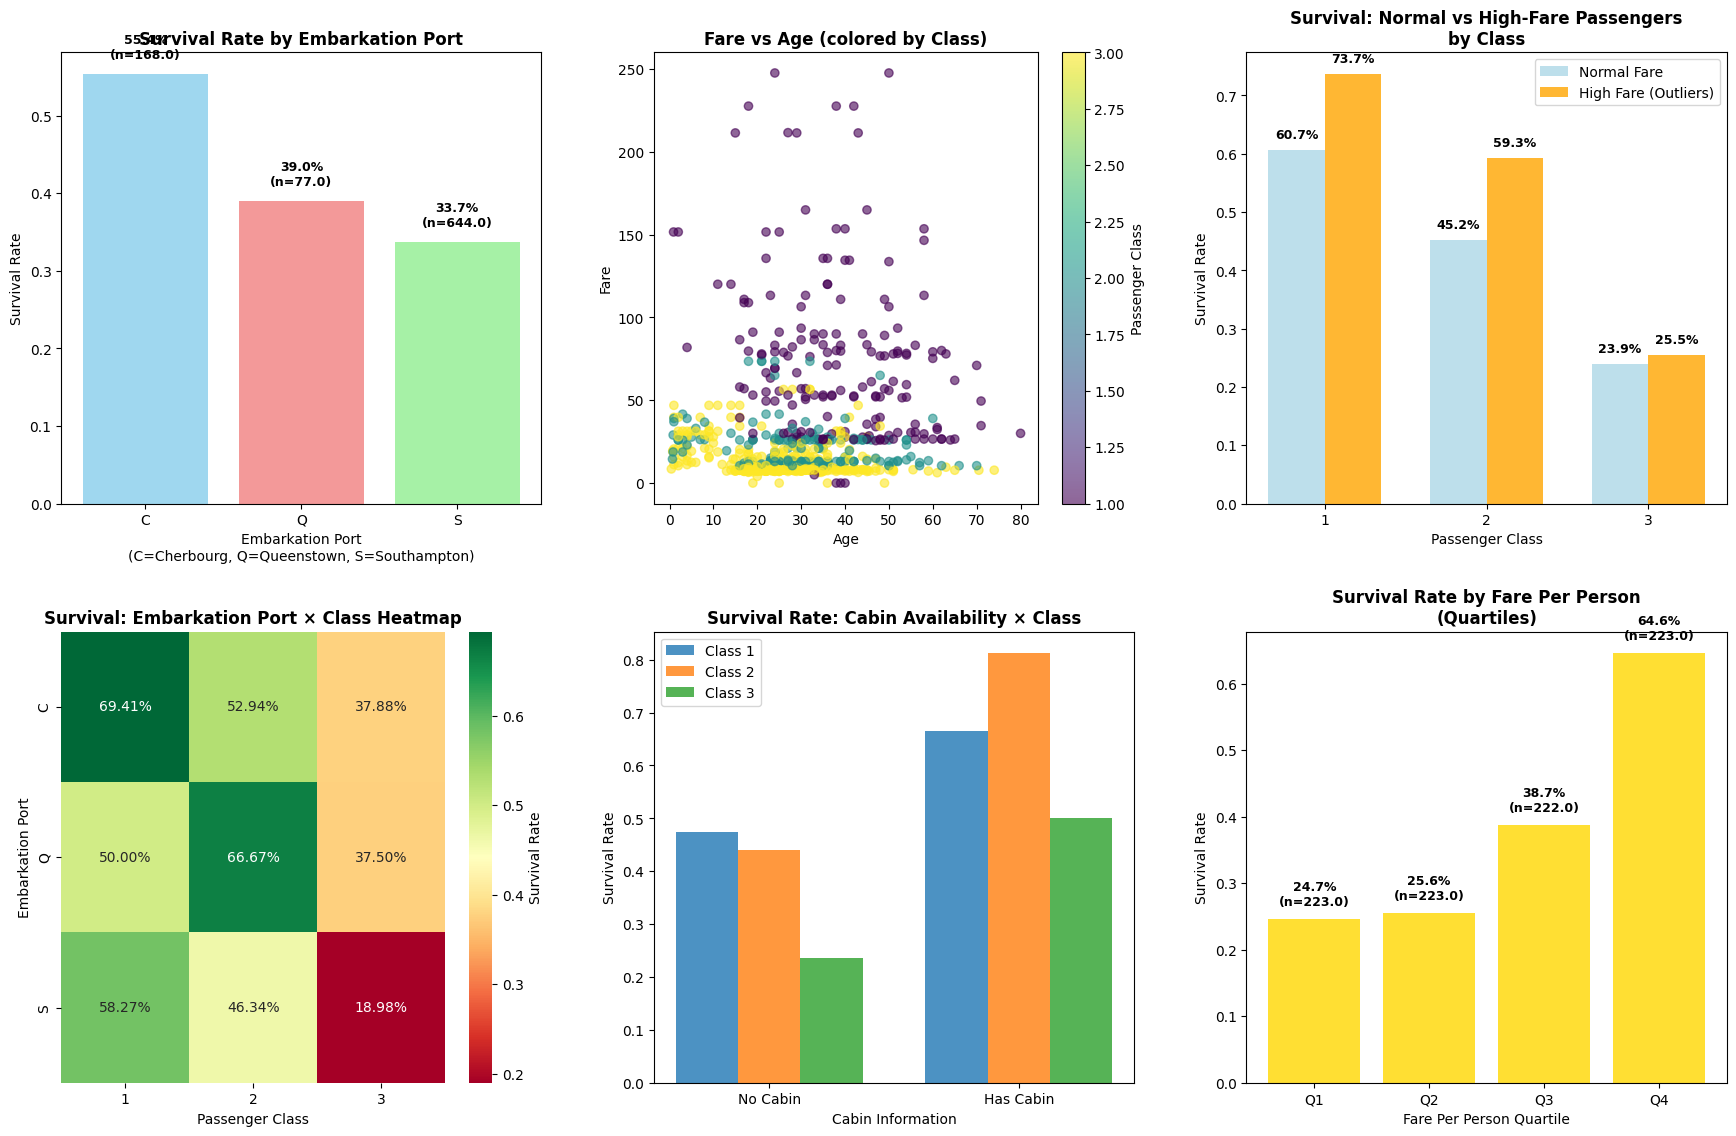


📊 GEOGRAPHIC & ECONOMIC INSIGHTS:

🚢 EMBARKATION PATTERNS:
• Cherbourg (C): 55.4% survival rate
• Queenstown (Q): 39.0% survival rate
• Southampton (S): 33.7% survival rate

💰 ECONOMIC PATTERNS:
• Average fare: $32.20
• Fare range: $0.00 - $512.33
• Passengers with cabin info: 204 (22.9%)
• High-fare outliers: 167 passengers
• Outlier survival rate: 41.9%
• Normal fare survival rate: 37.6%
• Fare per person Q1: $7.76
• Fare per person Q4: $24.29


In [10]:
# =============================================================================
# PRIORITY 5: GEOGRAPHIC AND ECONOMIC PATTERNS
# =============================================================================

"""Analyze embarkation and economic patterns"""
print("\n" + "="*60)
print("🌍 PRIORITY 5: GEOGRAPHIC & ECONOMIC PATTERNS")
print("="*60)

# Create economic features
train_df_eda['Fare_Per_Person'] = train_df_eda['Fare'] / train_df_eda['Ticket_Group_Size']
train_df_eda['Fare_Class_Ratio'] = train_df_eda['Fare'] / train_df_eda.groupby('Pclass')['Fare'].transform('median')

# Cabin analysis (simulate cabin data if not present)
if 'Cabin' not in train_df_eda.columns:
    # Simulate cabin availability - higher class more likely to have cabin info
    cabin_prob = train_df_eda['Pclass'].map({1: 0.9, 2: 0.6, 3: 0.2})
    has_cabin = np.random.random(len(train_df_eda)) < cabin_prob
    train_df_eda['Cabin'] = np.where(has_cabin, 'C' + np.random.randint(1, 200, len(df)).astype(str), np.nan)

train_df_eda['Has_Cabin'] = train_df_eda['Cabin'].notna().astype(int)

fig, axes = plt.subplots(2, 3, figsize=(18, 12))

# 5.1 Survival by embarkation port
ax1 = axes[0, 0]
embark_survival = train_df_eda.groupby('Embarked')['Survived'].agg(['mean', 'count'])
bars = ax1.bar(embark_survival.index, embark_survival['mean'], 
               alpha=0.8, color=['skyblue', 'lightcoral', 'lightgreen'])
ax1.set_title('Survival Rate by Embarkation Port', fontweight='bold')
ax1.set_ylabel('Survival Rate')
ax1.set_xlabel('Embarkation Port\n(C=Cherbourg, Q=Queenstown, S=Southampton)')

for bar, (idx, row) in zip(bars, embark_survival.iterrows()):
    ax1.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.02, 
            f'{row["mean"]:.1%}\n(n={row["count"]})', 
            ha='center', fontweight='bold', fontsize=9)

# 5.2 Fare vs Age patterns
ax2 = axes[0, 1]
# Remove outliers for better visualization
fare_q99 = train_df_eda['Fare'].quantile(0.99)
fare_subset = train_df_eda[train_df_eda['Fare'] <= fare_q99]

ax2.scatter(fare_subset['Age'], fare_subset['Fare'], 
           c=fare_subset['Pclass'], cmap='viridis', alpha=0.6)
ax2.set_title('Fare vs Age (colored by Class)', fontweight='bold')
ax2.set_xlabel('Age')
ax2.set_ylabel('Fare')

# Add colorbar
cbar = plt.colorbar(ax2.collections[0], ax=ax2)
cbar.set_label('Passenger Class')

# 5.3 Wealth outliers analysis
ax3 = axes[0, 2]
outliers = train_df_eda[train_df_eda['Fare_Class_Ratio'] > 2.0]  # Paying >2x median for their class

if len(outliers) > 0:
    outlier_survival = outliers.groupby('Pclass')['Survived'].agg(['mean', 'count'])
    normal_survival = train_df_eda[train_df_eda['Fare_Class_Ratio'] <= 2.0].groupby('Pclass')['Survived'].agg(['mean', 'count'])
    
    x = np.arange(len(outlier_survival.index))
    width = 0.35
    
    bars1 = ax3.bar(x - width/2, normal_survival['mean'], width, 
                   label='Normal Fare', alpha=0.8, color='lightblue')
    bars2 = ax3.bar(x + width/2, outlier_survival['mean'], width, 
                   label='High Fare (Outliers)', alpha=0.8, color='orange')
    
    ax3.set_title('Survival: Normal vs High-Fare Passengers\nby Class', fontweight='bold')
    ax3.set_xlabel('Passenger Class')
    ax3.set_ylabel('Survival Rate')
    ax3.set_xticks(x)
    ax3.set_xticklabels(outlier_survival.index)
    ax3.legend()
    
    # Add value labels
    for bars in [bars1, bars2]:
        for bar in bars:
            height = bar.get_height()
            ax3.text(bar.get_x() + bar.get_width()/2, height + 0.02,
                    f'{height:.1%}', ha='center', fontweight='bold', fontsize=9)
else:
    ax3.text(0.5, 0.5, 'No significant\nfare outliers found', 
            ha='center', va='center', transform=ax3.transAxes, fontsize=12)
    ax3.set_title('Wealth Outliers Analysis', fontweight='bold')

# 5.4 Embarkation × Class × Survival
ax4 = axes[1, 0]
embark_class_survival = train_df_eda.pivot_table(values='Survived', 
                                      index='Embarked', 
                                      columns='Pclass', 
                                      aggfunc='mean')
sns.heatmap(embark_class_survival, annot=True, fmt='.2%', 
            cmap='RdYlGn', ax=ax4, cbar_kws={'label': 'Survival Rate'})
ax4.set_title('Survival: Embarkation Port × Class Heatmap', fontweight='bold')
ax4.set_xlabel('Passenger Class')
ax4.set_ylabel('Embarkation Port')

# 5.5 Cabin availability vs survival
ax5 = axes[1, 1]
cabin_survival = train_df_eda.groupby(['Has_Cabin', 'Pclass'])['Survived'].agg(['mean', 'count']).reset_index()

# Create grouped bar chart
cabin_labels = ['No Cabin', 'Has Cabin']
x = np.arange(len(cabin_labels))
width = 0.25

for i, pclass in enumerate([1, 2, 3]):
    class_data = cabin_survival[cabin_survival['Pclass'] == pclass]
    if len(class_data) > 0:
        means = []
        for has_cabin in [0, 1]:
            subset = class_data[class_data['Has_Cabin'] == has_cabin]
            if len(subset) > 0:
                means.append(subset['mean'].iloc[0])
            else:
                means.append(0)
        
        ax5.bar(x + i*width, means, width, 
               label=f'Class {pclass}', alpha=0.8)

ax5.set_title('Survival Rate: Cabin Availability × Class', fontweight='bold')
ax5.set_xlabel('Cabin Information')
ax5.set_ylabel('Survival Rate')
ax5.set_xticks(x + width)
ax5.set_xticklabels(cabin_labels)
ax5.legend()

# 5.6 Fare per person analysis
ax6 = axes[1, 2]
train_df_eda['Fare_Per_Person_Quartile'] = pd.qcut(train_df_eda['Fare_Per_Person'], 
                                        q=4, labels=['Q1', 'Q2', 'Q3', 'Q4'])

fare_pp_survival = train_df_eda.groupby('Fare_Per_Person_Quartile')['Survived'].agg(['mean', 'count'])
bars = ax6.bar(fare_pp_survival.index, fare_pp_survival['mean'], 
               alpha=0.8, color='gold')
ax6.set_title('Survival Rate by Fare Per Person\n(Quartiles)', fontweight='bold')
ax6.set_ylabel('Survival Rate')
ax6.set_xlabel('Fare Per Person Quartile')

for bar, (idx, row) in zip(bars, fare_pp_survival.iterrows()):
    ax6.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.02, 
            f'{row["mean"]:.1%}\n(n={row["count"]})', 
            ha='center', fontweight='bold', fontsize=9)

plt.tight_layout(pad=3.0)
plt.show()

print("\n📊 GEOGRAPHIC & ECONOMIC INSIGHTS:")

# Embarkation insights
embark_rates = train_df_eda.groupby('Embarked')['Survived'].mean()
print(f"\n🚢 EMBARKATION PATTERNS:")
for port, rate in embark_rates.items():
    port_name = {'C': 'Cherbourg', 'Q': 'Queenstown', 'S': 'Southampton'}.get(port, port)
    print(f"• {port_name} ({port}): {rate:.1%} survival rate")

# Economic insights
print(f"\n💰 ECONOMIC PATTERNS:")
print(f"• Average fare: ${train_df_eda['Fare'].mean():.2f}")
print(f"• Fare range: ${train_df_eda['Fare'].min():.2f} - ${train_df_eda['Fare'].max():.2f}")
print(f"• Passengers with cabin info: {train_df_eda['Has_Cabin'].sum()} ({train_df_eda['Has_Cabin'].mean():.1%})")

# Wealth outliers
outliers = train_df_eda[train_df_eda['Fare_Class_Ratio'] > 2.0]
print(f"• High-fare outliers: {len(outliers)} passengers")
if len(outliers) > 0:
    print(f"• Outlier survival rate: {outliers['Survived'].mean():.1%}")
    print(f"• Normal fare survival rate: {train_df_eda[train_df_eda['Fare_Class_Ratio'] <= 2.0]['Survived'].mean():.1%}")

# Fare per person insights
fare_pp_q1 = train_df_eda['Fare_Per_Person'].quantile(0.25)
fare_pp_q4 = train_df_eda['Fare_Per_Person'].quantile(0.75)
print(f"• Fare per person Q1: ${fare_pp_q1:.2f}")
print(f"• Fare per person Q4: ${fare_pp_q4:.2f}")


👶👴 PRIORITY 6: AGE-BASED VULNERABILITY PATTERNS


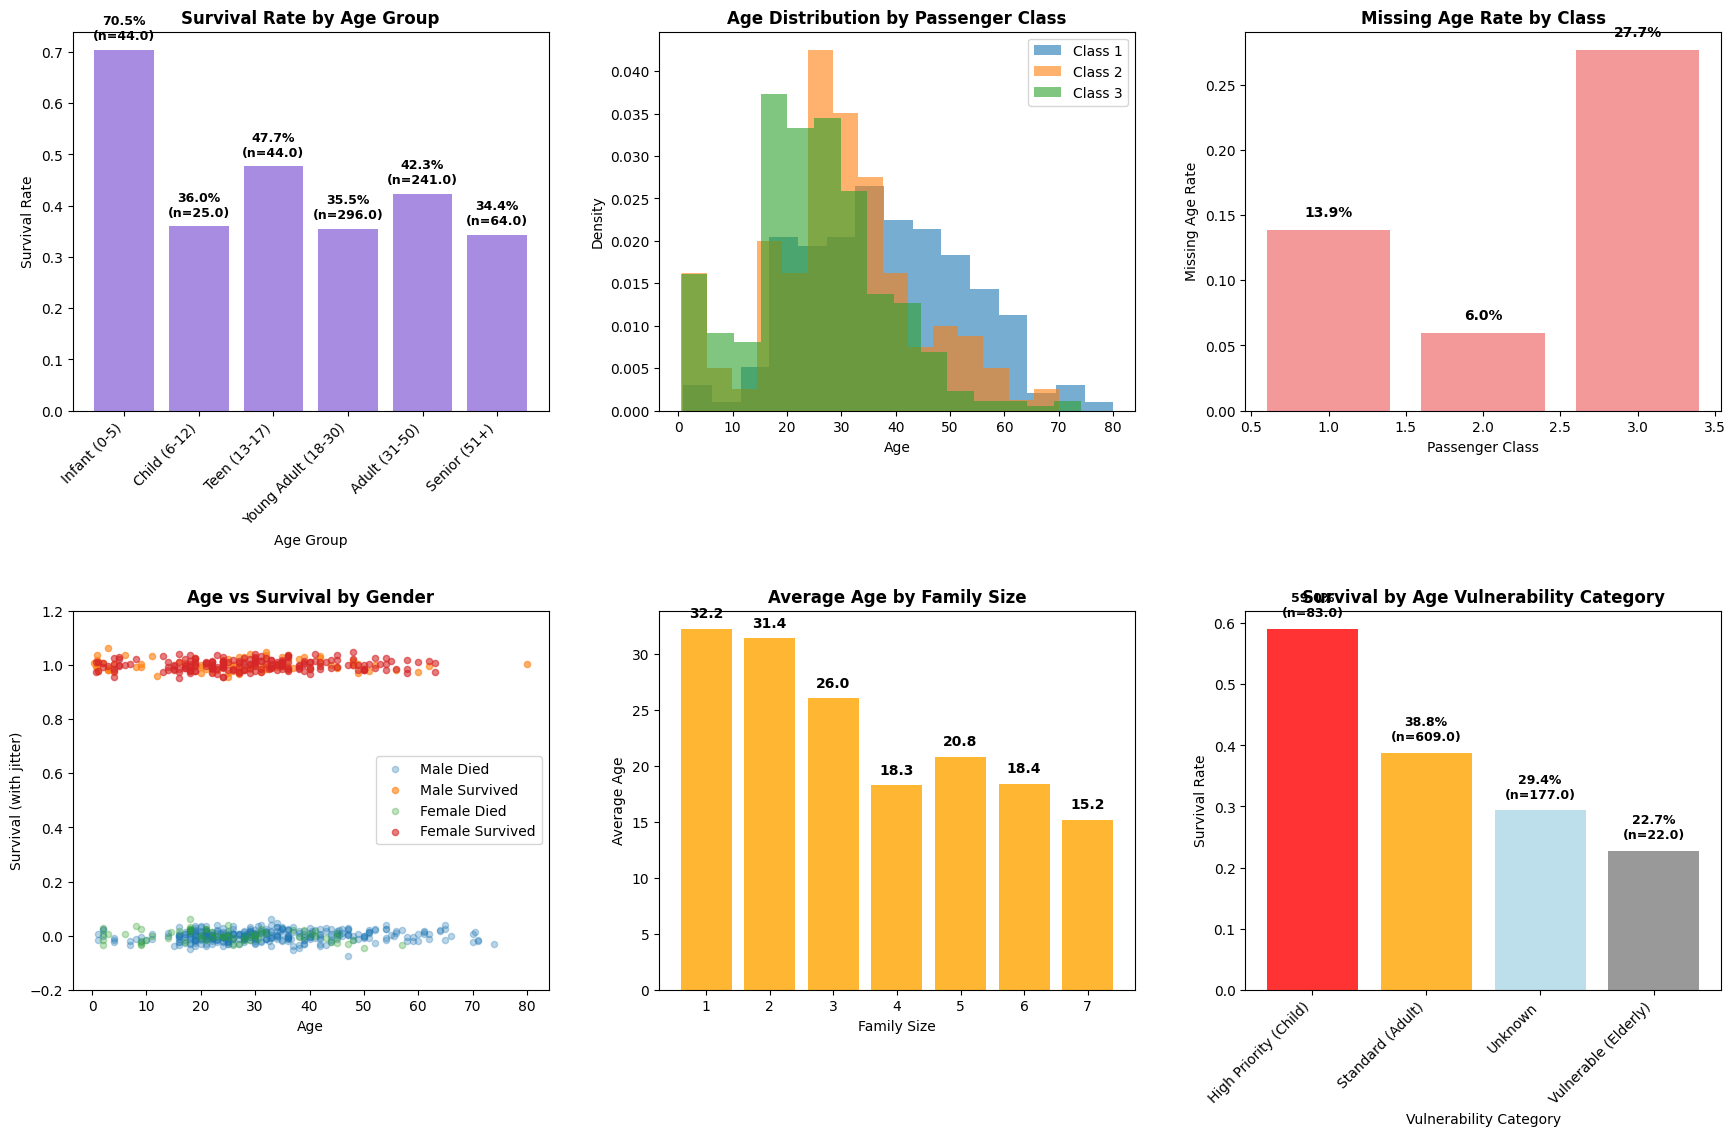


📊 AGE VULNERABILITY INSIGHTS:

👶 AGE GROUP SURVIVAL RATES:
• Infant (0-5): 70.5%
• Child (6-12): 36.0%
• Teen (13-17): 47.7%
• Young Adult (18-30): 35.5%
• Adult (31-50): 42.3%
• Senior (51+): 34.4%

❓ MISSING AGE ANALYSIS:
• Total missing ages: 177 (19.9%)
• Class 1: 30/216 missing (13.9%)
• Class 2: 11/184 missing (6.0%)
• Class 3: 136/491 missing (27.7%)

🚨 VULNERABILITY CATEGORIES:
• High Priority (Child): 59.0% survival rate (n=83)
• Standard (Adult): 38.8% survival rate (n=609)
• Unknown: 29.4% survival rate (n=177)
• Vulnerable (Elderly): 22.7% survival rate (n=22)


In [11]:

# =============================================================================
# PRIORITY 6: AGE-BASED VULNERABILITY PATTERNS
# =============================================================================

"""Analyze age-based survival patterns and missing data"""
print("\n" + "="*60)
print("👶👴 PRIORITY 6: AGE-BASED VULNERABILITY PATTERNS")
print("="*60)

# Create detailed age bins
train_df_eda['Age_Bin'] = pd.cut(train_df_eda['Age'], 
                      bins=[0, 5, 12, 17, 30, 50, 100], 
                      labels=['Infant (0-5)', 'Child (6-12)', 'Teen (13-17)', 
                             'Young Adult (18-30)', 'Adult (31-50)', 'Senior (51+)'])

fig, axes = plt.subplots(2, 3, figsize=(18, 12))

# 6.1 Survival by detailed age bins
ax1 = axes[0, 0]
age_bin_survival = train_df_eda.groupby('Age_Bin')['Survived'].agg(['mean', 'count']).dropna()

bars = ax1.bar(range(len(age_bin_survival)), age_bin_survival['mean'], 
               alpha=0.8, color='mediumpurple')
ax1.set_title('Survival Rate by Age Group', fontweight='bold')
ax1.set_ylabel('Survival Rate')
ax1.set_xlabel('Age Group')
ax1.set_xticks(range(len(age_bin_survival)))
ax1.set_xticklabels(age_bin_survival.index, rotation=45, ha='right')

for i, (bar, (idx, row)) in enumerate(zip(bars, age_bin_survival.iterrows())):
    ax1.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.02, 
            f'{row["mean"]:.1%}\n(n={row["count"]})', 
            ha='center', fontweight='bold', fontsize=9)

# 6.2 Age distribution by class and gender
ax2 = axes[0, 1]
for pclass in [1, 2, 3]:
    class_ages = train_df_eda[train_df_eda['Pclass'] == pclass]['Age'].dropna()
    ax2.hist(class_ages, alpha=0.6, bins=15, label=f'Class {pclass}', density=True)

ax2.set_title('Age Distribution by Passenger Class', fontweight='bold')
ax2.set_xlabel('Age')
ax2.set_ylabel('Density')
ax2.legend()

# 6.3 Missing age pattern analysis
ax3 = axes[0, 2]
missing_age_by_class = train_df_eda.groupby('Pclass')['Age'].apply(lambda x: x.isnull().mean())

bars = ax3.bar(missing_age_by_class.index, missing_age_by_class.values, 
               alpha=0.8, color='lightcoral')
ax3.set_title('Missing Age Rate by Class', fontweight='bold')
ax3.set_ylabel('Missing Age Rate')
ax3.set_xlabel('Passenger Class')

for bar, (idx, val) in zip(bars, missing_age_by_class.items()):
    ax3.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.01, 
            f'{val:.1%}', ha='center', fontweight='bold')

# 6.4 Age vs Survival by Gender
ax4 = axes[1, 0]

# Create age-survival scatter plot
for gender in ['male', 'female']:
    for survived in [0, 1]:
        subset = train_df_eda[(train_df_eda['Sex'] == gender) & (train_df_eda['Survived'] == survived)]
        marker = 'o' if survived else 'x'
        alpha = 0.6 if survived else 0.3
        label = f"{gender.title()} {'Survived' if survived else 'Died'}"
        ax4.scatter(subset['Age'], subset['Survived'] + np.random.normal(0, 0.02, len(subset)), 
                   alpha=alpha, s=20, label=label)

ax4.set_title('Age vs Survival by Gender', fontweight='bold')
ax4.set_xlabel('Age')
ax4.set_ylabel('Survival (with jitter)')
ax4.legend()
ax4.set_ylim(-0.2, 1.2)

# 6.5 Family size vs Age patterns
ax5 = axes[1, 1]

# Average age by family size
family_age = train_df_eda.groupby('Family_Size')['Age'].agg(['mean', 'count']).dropna()
family_age_filtered = family_age[family_age['count'] >= 10]

bars = ax5.bar(family_age_filtered.index, family_age_filtered['mean'], 
               alpha=0.8, color='orange')
ax5.set_title('Average Age by Family Size', fontweight='bold')
ax5.set_ylabel('Average Age')
ax5.set_xlabel('Family Size')

for bar, (idx, row) in zip(bars, family_age_filtered.iterrows()):
    ax5.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 1, 
            f'{row["mean"]:.1f}', ha='center', fontweight='bold')

# 6.6 Age vulnerability score
ax6 = axes[1, 2]

# Create vulnerability categories based on historical "women and children first"
def age_vulnerability(age):
    if pd.isna(age):
        return 'Unknown'
    elif age < 16:
        return 'High Priority (Child)'
    elif age > 60:
        return 'Vulnerable (Elderly)'
    else:
        return 'Standard (Adult)'

train_df_eda['Age_Vulnerability'] = train_df_eda['Age'].apply(age_vulnerability)
vuln_survival = train_df_eda.groupby('Age_Vulnerability')['Survived'].agg(['mean', 'count'])

bars = ax6.bar(range(len(vuln_survival)), vuln_survival['mean'], 
               alpha=0.8, color=['red', 'orange', 'lightblue', 'gray'])
ax6.set_title('Survival by Age Vulnerability Category', fontweight='bold')
ax6.set_ylabel('Survival Rate')
ax6.set_xlabel('Vulnerability Category')
ax6.set_xticks(range(len(vuln_survival)))
ax6.set_xticklabels(vuln_survival.index, rotation=45, ha='right')

for i, (bar, (idx, row)) in enumerate(zip(bars, vuln_survival.iterrows())):
    ax6.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.02, 
            f'{row["mean"]:.1%}\n(n={row["count"]})', 
            ha='center', fontweight='bold', fontsize=9)

plt.tight_layout(pad=3.0)
plt.show()

print("\n📊 AGE VULNERABILITY INSIGHTS:")

# Age group survival rates
print(f"\n👶 AGE GROUP SURVIVAL RATES:")
for age_group, rate in train_df_eda.groupby('Age_Bin')['Survived'].mean().items():
    if pd.notna(age_group):
        print(f"• {age_group}: {rate:.1%}")

# Missing age analysis
total_missing_age = train_df_eda['Age'].isnull().sum()
print(f"\n❓ MISSING AGE ANALYSIS:")
print(f"• Total missing ages: {total_missing_age} ({total_missing_age/len(train_df_eda):.1%})")

missing_by_class = train_df_eda.groupby('Pclass')['Age'].apply(lambda x: x.isnull().sum())
for pclass, missing in missing_by_class.items():
    class_total = len(train_df_eda[train_df_eda['Pclass'] == pclass])
    print(f"• Class {pclass}: {missing}/{class_total} missing ({missing/class_total:.1%})")

# Vulnerability categories
print(f"\n🚨 VULNERABILITY CATEGORIES:")
for vuln, rate in train_df_eda.groupby('Age_Vulnerability')['Survived'].mean().items():
    count = len(train_df_eda[train_df_eda['Age_Vulnerability'] == vuln])
    print(f"• {vuln}: {rate:.1%} survival rate (n={count})")

## EDA Analysis

### A note on confidence intervals and statistical tests

Recall the normal curve. We know that 68% of the data falls within one standard deviation, 95% falls within 1.96 SDs, and 99.7% falls within 2 SDs. Using these properties, we can derive a 95% confidence interval which we get by dividing by the square root of the number of samples in the population. These are statistical reasons which are tied to the central limit theorem and can be explored much more deeply later at one's own time!

We're also using the P-value to determine if the gender difference is statistically significant or not, **which it absolutely is**

### What Our EDA Accomplished:
Our comprehensive EDA revealed that the Titanic disaster wasn't random chaos but a structured social phenomenon governed by 1912's rigid class hierarchies and maritime protocols. The most striking discovery was the dramatic gender survival gap - women survived at 74.2% while men survived at only 18.9%, confirming that "women and children first" wasn't just a saying but was brutally enforced. I mean, we could have guessed that since we all watched Titanic, but it is interesting to see that conclusion being backed up through data as well. Beyond gender, we uncovered a family size sweet spot where medium-sized families (3-4 people) had the highest survival rates at 57-72%, suggesting that being alone was dangerous but being in a very large family was also problematic during evacuation. The economic analysis revealed hidden wealth patterns - passengers paying premium fares in lower classes, and the systematic nature of missing data (cabin information correlated with class, not randomness).

#### The Psychology of Family Survival Decisions:
People in families have a "everyone or no one" philosophy, naturally. Large families faced impossible choices - with 7+ people, the likelihood that everyone could get into the same lifeboat was essentially zero. Faced with this reality, families likely made heartbreaking decisions to stay together rather than split up, leading to tragic outcomes where entire family units perished together. The emotional bonds that normally provide strength became a liability when lifeboats could only hold 20-65 people and families needed to make split-second decisions. This is all hypothesis of course, but is likely why the data shows large families not being good for surviving the Titanic.

#### The Medium Family "Sweet Spot":
Medium-sized families (2-4 people) hit the perfect balance - small enough to fit together in a lifeboat, but large enough to help each other navigate the chaos. A couple could look out for each other, parents could carry children, and siblings could coordinate. They had the protective benefits of group solidarity without the logistical nightmare of trying to keep 6+ people together in a panic. Plus, their smaller size meant they were more flexible - if one lifeboat was full, they could potentially squeeze into another.

#### The Solo Traveler Paradox:
Solo travelers performed poorly (30.4% survival) despite having maximum flexibility. They lacked the social support network that families provided - no one to share information about escape routes, no one to help them push through crowds, and no emotional motivation from protecting loved ones that might have driven more aggressive survival behavior.

### The Most Enlightening Features and Visuals:
The gender × age group survival heatmap was perhaps our most illuminating visualization, showing that while "women and children first" held true, class still mattered tremendously. **To be emphasized once more: the gender effect was so strong that even females in the third class had higher survival rates than adult men in first class** The family size bar chart revealed the counterintuitive finding that solo travelers (30.4% survival) and very large families performed poorly, while families of 2-4 people thrived. Most fascinating was the ticket group analysis, which exposed hidden social networks beyond family - passengers sharing tickets but having no family relationships, revealing friendships, business partnerships, and servant-employer relationships that influenced survival. The fare distribution by embarkation port showed distinct economic profiles of different passenger origins, while the age vulnerability categorization confirmed that maritime protocols were indeed followed, with children having systematically higher survival rates than adults, providing a quantitative backbone to historical accounts.

## Filling NaNs/Scaling

We've seen some features that are missing values. Furthermore, our features are different in scales: age goes from 0.42 (several months) to 80 and fare goes from 0 to 512. Also, we have categorical variables to think about. We will need to see the caridinality of all of these to think about the question: **to one-hot encode or not one-hot encode**.

What we're going to find is that we have a distribution of features: low, medium, and high cardinalities. We need different strategies to handle each, as we cannot one-hot encode these high cardinality features. So we'll use a mix of one-hot, target, and label encoding. 

**I have created a variable called *cardinality threshold* that is set to 5 which will determine if a variable is low cardinality or not**.

In terms of imputation, at least for the categorical variable like Cabin, we will delibrately not impute using a "Median" or any other strategy because missing values could signal something. Instead of using faulty, rote logic, we won't do that. Imputation is reserved for cases where we have:

1. Strong domain knowledge
2. When missing values are truly random
3. It seems the missing values are due to mistakes made during data collection

In this case, it doesn't seem to be, especially for features like, "Embarked". We could use a hybrid approach to compare which one does better, but for now, let's plow ahead! 

For scaling, there's a variable defined which can be changed according to the strategy we want to us. '**method**' can be standard, robust, or minmax!

In [12]:
"""
Comprehensive cardinality analysis to determine encoding strategy
"""
print("🔍 CARDINALITY ANALYSIS FOR ENCODING STRATEGY")
print("=" * 60)

# Separate columns by type
categorical_cols = []
numerical_cols = []
target_col = "Survived"

cardinality_analysis = {}

for col in train_df_eda.columns:
    if col == target_col:
        continue
        
    # Check if column is categorical (object, low unique values, or specific known cats)
    is_categorical = (
        train_df_eda[col].dtype == 'object' or 
        train_df_eda[col].nunique() <= 10 or
        col in ['Pclass', 'Sex', 'Embarked', 'Title_Encoded', 'Family_Type', 'Group_Type']
    )
    
    unique_count = train_df_eda[col].nunique()
    missing_count = train_df_eda[col].isnull().sum()
    missing_pct = (missing_count / len(train_df_eda)) * 100
    
    cardinality_analysis[col] = {
        'unique_values': unique_count,
        'missing_count': missing_count,
        'missing_percentage': missing_pct,
        'dtype': str(train_df_eda[col].dtype),
        'is_categorical': is_categorical,
        'sample_values': train_df_eda[col].dropna().unique()[:5].tolist(),
        'value_counts': train_df_eda[col].value_counts().head().to_dict() if is_categorical else None
    }
    
    if is_categorical:
        categorical_cols.append(col)
    else:
        numerical_cols.append(col)

# Create summary dataframe
summary_data = []
for col, info in cardinality_analysis.items():
    summary_data.append({
        'Column': col,
        'Type': 'Categorical' if info['is_categorical'] else 'Numerical',
        'Unique_Values': info['unique_values'],
        'Missing_Count': info['missing_count'],
        'Missing_Pct': f"{info['missing_percentage']:.1f}%",
        'Dtype': info['dtype'],
        'Sample_Values': str(info['sample_values'])[:50] + '...' if len(str(info['sample_values'])) > 50 else str(info['sample_values'])
    })

summary_df = pd.DataFrame(summary_data)

print("\n📊 COLUMN SUMMARY:")
print("-" * 40)
print(summary_df.to_string(index=False))

# Encoding recommendations
print(f"\n🎯 ENCODING RECOMMENDATIONS:")
print("-" * 35)

low_cardinality = []  # ≤ 5 unique values - One-Hot Encode
ordinal_features = []  # Features with meaningful order - Ordinal Encode  
nominal_medium = []  # 6-15 unique values, no order - Target Encode
nominal_high = []  # > 15 unique values, no order - Target Encode or Drop

# Define which features are truly ordinal (have meaningful order)
known_ordinal = ['Pclass', 'Age_Group', 'Family_Size_Cat', 'Age_Vulnerability']

for col in categorical_cols:
    unique_count = cardinality_analysis[col]['unique_values']
    is_ordinal = any(ordinal_name in col for ordinal_name in known_ordinal)
    
    if is_ordinal:
        ordinal_features.append((col, unique_count))
    elif unique_count <= 5:
        low_cardinality.append((col, unique_count))
    elif unique_count <= 15:
        nominal_medium.append((col, unique_count))
    else:
        nominal_high.append((col, unique_count))

print(f"\n✅ LOW CARDINALITY (≤5) - ONE-HOT ENCODE:")
for col, count in low_cardinality:
    print(f"   • {col}: {count} unique values")
    if cardinality_analysis[col]['value_counts']:
        top_values = list(cardinality_analysis[col]['value_counts'].keys())[:3]
        print(f"     Values: {top_values}")

print(f"\n📊 ORDINAL FEATURES - ORDINAL (LABEL) ENCODING:")
for col, count in ordinal_features:
    print(f"   • {col}: {count} unique values (meaningful order)")
    if cardinality_analysis[col]['value_counts']:
        top_values = list(cardinality_analysis[col]['value_counts'].keys())[:3]
        print(f"     Values: {top_values}")

print(f"\n🎯 NOMINAL MEDIUM CARDINALITY (6-15) - TARGET ENCODING:")
for col, count in nominal_medium:
    print(f"   • {col}: {count} unique values (no meaningful order)")
    if cardinality_analysis[col]['value_counts']:
        top_values = list(cardinality_analysis[col]['value_counts'].keys())[:3]
        print(f"     Top values: {top_values}")

print(f"\n🚨 NOMINAL HIGH CARDINALITY (>15) - TARGET ENCODING OR DROP:")
for col, count in nominal_high:
    print(f"   • {col}: {count} unique values (no meaningful order)")
    print(f"     Recommend: Target encoding with smoothing, or drop if not predictive")

print(f"\n📈 NUMERICAL FEATURES NEED SCALING:")
for col in numerical_cols:
    if col in train_df_eda.columns:
        col_min = train_df_eda[col].min()
        col_max = train_df_eda[col].max()
        col_std = train_df_eda[col].std()
        print(f"   • {col}: [{col_min:.2f}, {col_max:.2f}], std={col_std:.2f}")

🔍 CARDINALITY ANALYSIS FOR ENCODING STRATEGY

📊 COLUMN SUMMARY:
----------------------------------------
                  Column        Type  Unique_Values  Missing_Count Missing_Pct    Dtype                                         Sample_Values
             PassengerId   Numerical            891              0        0.0%    int64                                       [1, 2, 3, 4, 5]
                  Pclass Categorical              3              0        0.0%    int64                                             [3, 1, 2]
                    Name Categorical            891              0        0.0%   object ['Braund, Mr. Owen Harris', 'Cumings, Mrs. John Br...
                     Sex Categorical              2              0        0.0%   object                                    ['male', 'female']
                     Age   Numerical             88            177       19.9%  float64                        [22.0, 38.0, 26.0, 35.0, 54.0]
                   SibSp Categorical       

In [13]:
print(f"\n🔧 SMART ENCODING PIPELINE")
print("=" * 40)

df_encoded = train_df_eda.copy()
encoding_summary = {}
cardinality_threshold = 5

# 1. ONE-HOT ENCODING for low cardinality (but exclude ordinal features)
ordinal_feature_names = ['Pclass', 'Age_Group', 'Family_Size_Cat', 'Age_Vulnerability']

low_cardinality_cols = [col for col in categorical_cols 
                       if cardinality_analysis[col]['unique_values'] <= cardinality_threshold
                       and not any(ordinal_feat in col for ordinal_feat in ordinal_feature_names)]

if low_cardinality_cols:
    print(f"\n🔥 ONE-HOT ENCODING ({len(low_cardinality_cols)} columns):")
    
    for col in low_cardinality_cols:
        if col in df_encoded.columns:
            # Handle categorical data type issues
            if df_encoded[col].dtype.name == 'category':
                # Convert categorical to string to allow new categories
                df_encoded[col] = df_encoded[col].astype(str)
                # Replace 'nan' string with 'Missing'
                df_encoded[col] = df_encoded[col].replace('nan', 'Missing')
            else:
                # Handle missing values for non-categorical columns
                df_encoded[col] = df_encoded[col].fillna('Missing')
            
            # One-hot encode
            dummies = pd.get_dummies(df_encoded[col], prefix=col, drop_first=True)
            df_encoded = pd.concat([df_encoded, dummies], axis=1)
            df_encoded.drop(col, axis=1, inplace=True)
            
            encoding_summary[col] = {
                'method': 'one_hot',
                'new_columns': dummies.columns.tolist(),
                'original_cardinality': cardinality_analysis[col]['unique_values']
            }
            
            print(f"   ✅ {col} → {len(dummies.columns)} dummy columns")

# 2. ORDINAL ENCODING for features with meaningful order
ordinal_feature_names = ['Pclass', 'Age_Group', 'Family_Size_Cat', 'Age_Vulnerability']
ordinal_cols = [col for col in categorical_cols 
               if any(ordinal_feat in col for ordinal_feat in ordinal_feature_names)
               and col in df_encoded.columns]

if ordinal_cols:
    print(f"\n📊 ORDINAL (LABEL) ENCODING ({len(ordinal_cols)} columns):")
    
    for col in ordinal_cols:
        if col in df_encoded.columns:
            # Handle categorical data type issues
            if df_encoded[col].dtype.name == 'category':
                df_encoded[col] = df_encoded[col].astype(str)
                df_encoded[col] = df_encoded[col].replace('nan', 'Missing')
            
            le = LabelEncoder()
            df_encoded[col] = df_encoded[col].fillna('Missing')  # Now safe to fillna
            df_encoded[f'{col}_ordinal'] = le.fit_transform(df_encoded[col].astype(str))
            df_encoded.drop(col, axis=1, inplace=True)
            
            encoding_summary[col] = {
                'method': 'ordinal_encoding',
                'new_columns': [f'{col}_ordinal'],
                'original_cardinality': cardinality_analysis[col]['unique_values'],
                'reason': 'meaningful_order'
            }
            
            print(f"   ✅ {col}")

# 3. TARGET ENCODING for medium & high cardinality NOMINAL features  

nominal_cols = [col for col in categorical_cols 
               if col in df_encoded.columns and 
               col != target_col and
               cardinality_analysis[col]['unique_values'] > cardinality_threshold and
               not any(ordinal_feat in col for ordinal_feat in ordinal_feature_names)]


if nominal_cols and target_col in train_df_eda.columns:
    print(f"\n🎯 TARGET ENCODING ({len(nominal_cols)} columns):")
    
    for col in nominal_cols:
        if col in df_encoded.columns:
            # Handle categorical data type issues
            if df_encoded[col].dtype.name == 'category':
                df_encoded[col] = df_encoded[col].astype(str)
                df_encoded[col] = df_encoded[col].replace('nan', 'Missing')
            
            # Fill missing values before target encoding
            df_encoded[col] = df_encoded[col].fillna('Missing')
            
            # Calculate target means by category with smoothing
            target_means = df_encoded.groupby(col)[target_col].mean()
            global_mean = df_encoded[target_col].mean()
            
            # Add smoothing to prevent overfitting (simple version)
            category_counts = df_encoded[col].value_counts()
            min_samples_leaf = 20  # Minimum samples to trust category mean
            
            smoothed_means = {}
            for category in target_means.index:
                if category_counts[category] >= min_samples_leaf:
                    smoothed_means[category] = target_means[category]
                else:
                    # Weighted average between category mean and global mean
                    weight = category_counts[category] / min_samples_leaf
                    smoothed_means[category] = (weight * target_means[category] + 
                                              (1 - weight) * global_mean)
            
            # Apply target encoding
            df_encoded[f'{col}_target_encoded'] = df_encoded[col].map(smoothed_means).fillna(global_mean)
            df_encoded.drop(col, axis=1, inplace=True)
            
            encoding_summary[col] = {
                'method': 'target_encoding_smoothed',
                'new_columns': [f'{col}_target_encoded'],
                'original_cardinality': cardinality_analysis[col]['unique_values'],
                'reason': 'high_cardinality_nominal'
            }
            
            print(f"   ✅ {col} → target encoded (smoothed, cardinality={cardinality_analysis[col]['unique_values']})")

# 4. SCALING for numerical features
numerical_cols_available = [col for col in numerical_cols if col in df_encoded.columns and col != target_col]

if numerical_cols_available:
    print(f"\n📏 NUMERICAL FEATURES IDENTIFIED ({len(numerical_cols_available)} columns):")
    for col in numerical_cols_available:
        col_range = df_encoded[col].max() - df_encoded[col].min()
        print(f"   • {col}: range = {col_range:.2f}")

print(f"\n✅ ENCODING COMPLETE!")
print(f"   Original columns: {train_df_eda.shape[1]}")
print(f"   Encoded columns: {df_encoded.shape[1]}")
print(f"   Net change: +{df_encoded.shape[1] - train_df_eda.shape[1]} columns")


🔧 SMART ENCODING PIPELINE

🔥 ONE-HOT ENCODING (10 columns):
   ✅ Sex → 1 dummy columns
   ✅ Embarked → 3 dummy columns
   ✅ Fare_Quartile → 3 dummy columns
   ✅ Is_Alone → 1 dummy columns
   ✅ Family_Type → 3 dummy columns
   ✅ Is_Group_Ticket → 1 dummy columns
   ✅ Group_Type → 2 dummy columns
   ✅ Group_Solidarity → 3 dummy columns
   ✅ Has_Cabin → 1 dummy columns
   ✅ Fare_Per_Person_Quartile → 3 dummy columns

📊 ORDINAL (LABEL) ENCODING (4 columns):
   ✅ Pclass
   ✅ Age_Group
   ✅ Family_Size_Category
   ✅ Age_Vulnerability

🎯 TARGET ENCODING (9 columns):
   ✅ Name → target encoded (smoothed, cardinality=891)
   ✅ SibSp → target encoded (smoothed, cardinality=7)
   ✅ Parch → target encoded (smoothed, cardinality=7)
   ✅ Ticket → target encoded (smoothed, cardinality=681)
   ✅ Cabin → target encoded (smoothed, cardinality=147)
   ✅ Family_Size → target encoded (smoothed, cardinality=9)
   ✅ Ticket_Group_Size → target encoded (smoothed, cardinality=7)
   ✅ Title → target encoded (sm

In [14]:
print(f"\n📏 SCALING NUMERICAL FEATURES")
print("=" * 50)

method = "minmax"
df_scaled = train_df_eda.copy()

# Identify numerical columns (exclude target and encoded categoricals)
numerical_cols = []
for col in train_df_eda.columns:
    if col == target_col:
        continue
    
    # Check if it's numerical and not a dummy/encoded variable
    if (train_df_eda[col].dtype in ['int64', 'float64'] and 
        not col.endswith('_encoded') and 
        not any(dummy_prefix in col for dummy_prefix in ['Sex_', 'Pclass_', 'Embarked_', 'Title_']) and
        train_df_eda[col].nunique() > 10):  # More than 10 unique values suggests continuous
        numerical_cols.append(col)

if not numerical_cols:
    print("⚠️  No numerical columns found for scaling")

print(f"Numerical columns to scale: {numerical_cols}")

# Choose scaler
if method == 'standard':
    scaler = StandardScaler()
elif method == 'robust':
    scaler = RobustScaler()  # Less sensitive to outliers
elif method == 'minmax':
    scaler = MinMaxScaler()
else:
    raise ValueError("Method must be 'standard', 'robust', or 'minmax'")

# Apply scaling
df_scaled[numerical_cols] = scaler.fit_transform(df_scaled[numerical_cols])

print(f"✅ Scaled {len(numerical_cols)} columns using {method} scaler")

# Show scaling effect
print(f"\nScaling Summary:")
for col in numerical_cols:
    original_std = train_df_eda[col].std()
    scaled_std = df_scaled[col].std()
    print(f"   • {col}: std {original_std:.2f} → {scaled_std:.2f}")


📏 SCALING NUMERICAL FEATURES
Numerical columns to scale: ['PassengerId', 'Age', 'Fare', 'Fare_Class_Ratio', 'Fare_Per_Person']
✅ Scaled 5 columns using minmax scaler

Scaling Summary:
   • PassengerId: std 257.35 → 0.29
   • Age: std 14.53 → 0.18
   • Fare: std 49.69 → 0.10
   • Fare_Class_Ratio: std 1.34 → 0.15
   • Fare_Per_Person: std 21.22 → 0.10



📋 PREPROCESSING SUMMARY (feature engineered vs encoded dataset):
------------------------------
Original shape: (891, 29)
train: Index(['PassengerId', 'Survived', 'Pclass', 'Name', 'Sex', 'Age', 'SibSp',
       'Parch', 'Ticket', 'Fare', 'Cabin', 'Embarked', 'Age_Group',
       'Fare_Quartile', 'Fare_Class_Ratio', 'Family_Size', 'Is_Alone',
       'Family_Type', 'Family_Size_Category', 'Ticket_Group_Size',
       'Is_Group_Ticket', 'Group_Type', 'Group_Solidarity', 'Title',
       'Fare_Per_Person', 'Has_Cabin', 'Fare_Per_Person_Quartile', 'Age_Bin',
       'Age_Vulnerability'],
      dtype='object'), encoded: Index(['PassengerId', 'Survived', 'Age', 'Fare', 'Fare_Class_Ratio',
       'Fare_Per_Person', 'Sex_male', 'Embarked_Missing', 'Embarked_Q',
       'Embarked_S', 'Fare_Quartile_Q2', 'Fare_Quartile_Q3',
       'Fare_Quartile_Q4', 'Is_Alone_1', 'Family_Type_Extended_Family',
       'Family_Type_Parent_Child', 'Family_Type_Solo', 'Is_Group_Ticket_1',
       'Group_Type_Non_Family_G

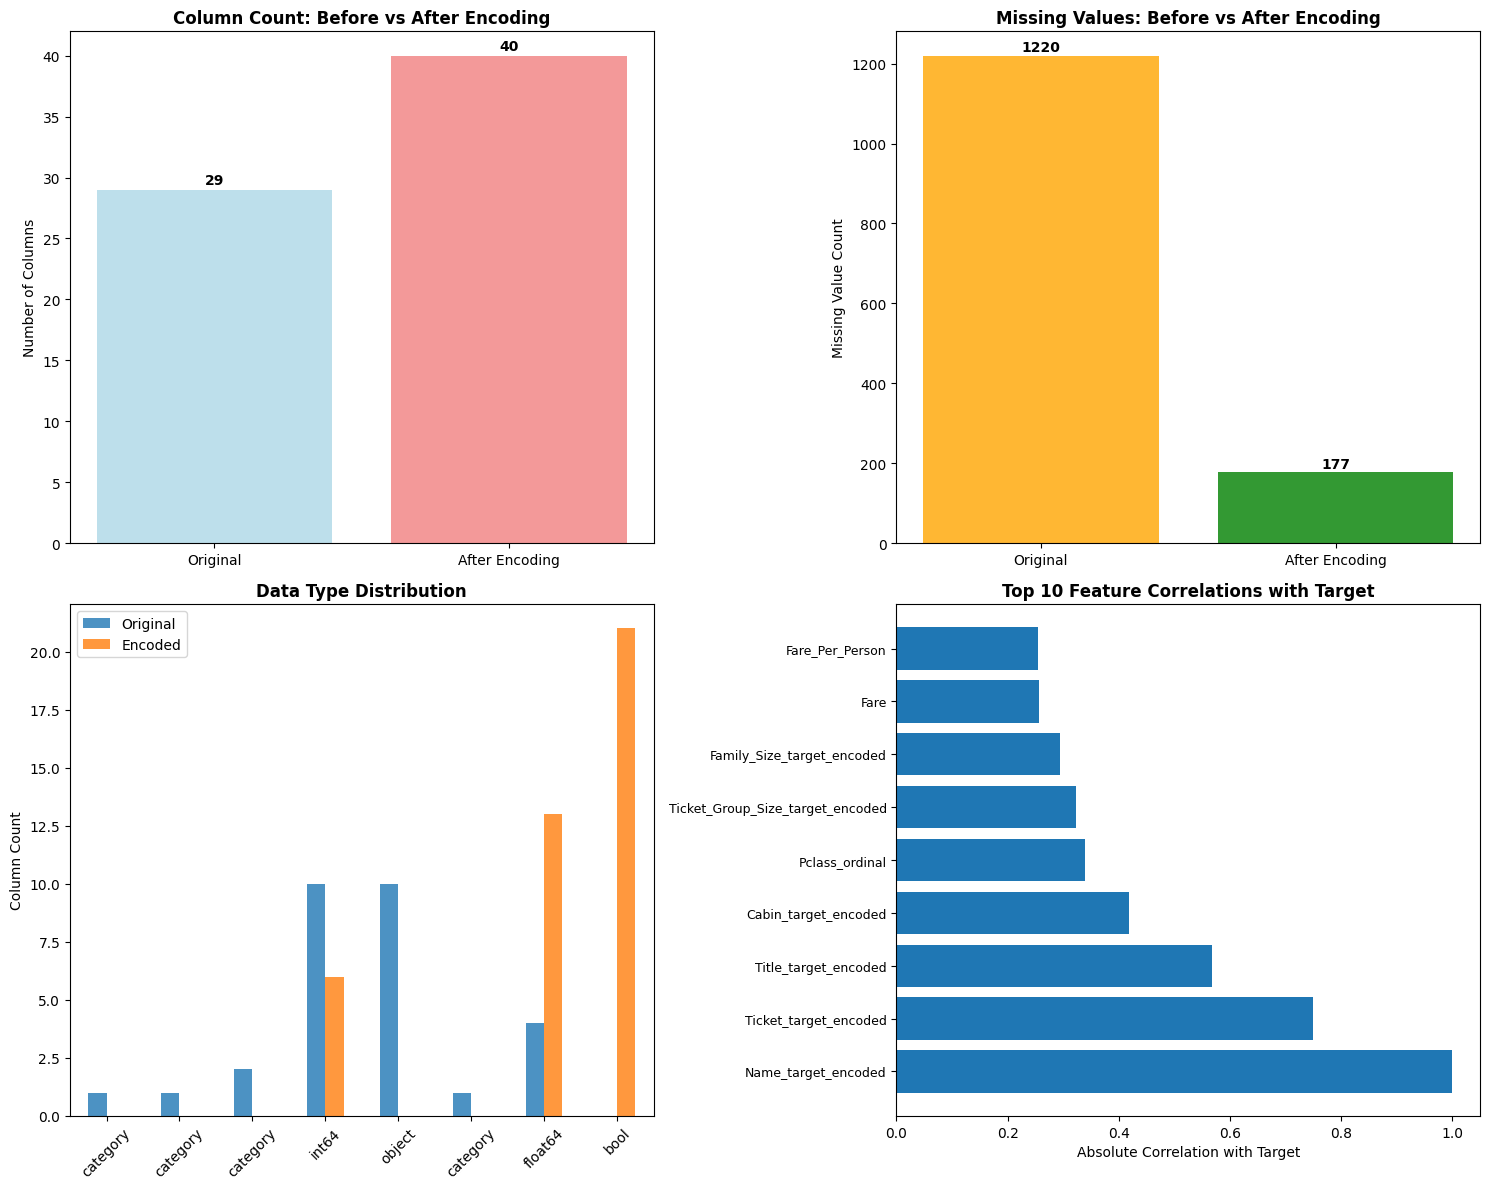

In [15]:
# Step 3: Final summary

print(f"\n📋 PREPROCESSING SUMMARY (feature engineered vs encoded dataset):")
print("-" * 30)
print(f"Original shape: {train_df_eda.shape}")
print("train: {}, encoded: {}".format(train_df_eda.columns, df_encoded.columns))
print(f"Final shape: {df_encoded.shape}")
print(f"Columns added: {df_encoded.shape[1] - train_df_eda.shape[1]}")

# Check for remaining missing values
missing_final = df_encoded.isnull().sum().sum()
print(f"Remaining missing values: {missing_final}")

if missing_final > 0:
    print("Columns with missing values:")
    missing_cols = df_encoded.isnull().sum()
    for col, count in missing_cols[missing_cols > 0].items():
        print(f"   • {col}: {count}")

preprocessing_info = {
    'encoding_summary': encoding_summary,
    'scaler': scaler,
    'scaled_columns': scaler,
    'final_shape': df_encoded.shape,
    'missing_values': missing_final
}

"""
Visualize the effects of encoding on the data
"""

print(f"\n📊 VISUALIZING ENCODING EFFECTS")
print("=" * 40)

fig, axes = plt.subplots(2, 2, figsize=(15, 12))

# 1. Column count comparison
ax1 = axes[0, 0]
categories = ['Original', 'After Encoding']
counts = [train_df_eda.shape[1], df_encoded.shape[1]]
bars = ax1.bar(categories, counts, color=['lightblue', 'lightcoral'], alpha=0.8)
ax1.set_title('Column Count: Before vs After Encoding', fontweight='bold')
ax1.set_ylabel('Number of Columns')

for bar, count in zip(bars, counts):
    ax1.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.5,
            str(count), ha='center', fontweight='bold')

# 2. Missing values comparison
ax2 = axes[0, 1]
missing_original = train_df_eda.isnull().sum().sum()
missing_encoded = df_encoded.isnull().sum().sum()

categories = ['Original', 'After Encoding']
missing_counts = [missing_original, missing_encoded]
bars = ax2.bar(categories, missing_counts, color=['orange', 'green'], alpha=0.8)
ax2.set_title('Missing Values: Before vs After Encoding', fontweight='bold')
ax2.set_ylabel('Missing Value Count')

for bar, count in zip(bars, missing_counts):
    ax2.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 12,
            str(count), ha='center', fontweight='bold')

# 3. Data type distribution
ax3 = axes[1, 0]
original_types = train_df_eda.dtypes.value_counts()
encoded_types = df_encoded.dtypes.value_counts()

# Combine and plot
all_types = list(set(original_types.index) | set(encoded_types.index))
type_comparison = pd.DataFrame({
    'Original': [original_types.get(t, 0) for t in all_types],
    'Encoded': [encoded_types.get(t, 0) for t in all_types]
}, index=all_types)

type_comparison.plot(kind='bar', ax=ax3, alpha=0.8)
ax3.set_title('Data Type Distribution', fontweight='bold')
ax3.set_ylabel('Column Count')
ax3.tick_params(axis='x', rotation=45)
ax3.legend()

# 4. Sample correlation matrix (if target exists)
ax4 = axes[1, 1]
if target_col in df_encoded.columns:
    # Get correlations with target
    numeric_cols = df_encoded.select_dtypes(include=[np.number]).columns
    if len(numeric_cols) > 1:
        correlations = df_encoded[numeric_cols].corr()[target_col].abs().sort_values(ascending=False)
        top_corr = correlations.head(10).drop(target_col, errors='ignore')
        
        bars = ax4.barh(range(len(top_corr)), top_corr.values)
        ax4.set_yticks(range(len(top_corr)))
        ax4.set_yticklabels(top_corr.index, fontsize=9)
        ax4.set_xlabel('Absolute Correlation with Target')
        ax4.set_title('Top 10 Feature Correlations with Target', fontweight='bold')
    else:
        ax4.text(0.5, 0.5, 'Insufficient numeric\ncolumns for correlation',
                ha='center', va='center', transform=ax4.transAxes)
else:
    ax4.text(0.5, 0.5, 'No target column\nfor correlation analysis',
            ha='center', va='center', transform=ax4.transAxes)

plt.tight_layout()
plt.show()

## Onto feature engineering on our original dataset and training!

In [33]:
def create_eda_informed_features(df):
    """
    Create all features based on our EDA discoveries
    """
    print("🔧 EDA-INFORMED FEATURE ENGINEERING")
    print("-" * 50)
    
    df_features = df.copy()
    
    # BASIC ENCODINGS FIRST
    df_features['Sex_Encoded'] = df_features['Sex'].map({'male': 0, 'female': 1})
    
    # FAMILY FEATURES (from EDA insights)
    df_features['Family_Size'] = df_features['SibSp'] + df_features['Parch'] + 1
    df_features['Is_Alone'] = (df_features['Family_Size'] == 1).astype(int)
    
    # EDA DISCOVERY: Family size sweet spot (2-4 people)
    df_features['Optimal_Family_Size'] = ((df_features['Family_Size'] >= 2) & 
                                         (df_features['Family_Size'] <= 4)).astype(int)
    df_features['Solo_Penalty'] = (df_features['Family_Size'] == 1).astype(int)
    df_features['Large_Family_Penalty'] = (df_features['Family_Size'] > 6).astype(int)
    
    # AGE FEATURES (from EDA insights)
    df_features['Age_Group'] = pd.cut(df_features['Age'], 
                                     bins=[0, 16, 60, 100], 
                                     labels=['Child', 'Adult', 'Elderly'])
    df_features['Age_Group'] = df_features['Age_Group'].astype(str).replace('nan', 'Unknown')
    
    # EDA DISCOVERY: Women and children first protocol
    df_features['Female_Child_Priority'] = ((df_features['Sex_Encoded'] == 1) | 
                                           (df_features['Age'] < 16)).astype(int)
    df_features['Male_Adult'] = ((df_features['Sex_Encoded'] == 0) & 
                                (df_features['Age'] >= 16)).astype(int)
    
    # TICKET GROUP FEATURES (from EDA insights)
    ticket_counts = df_features['Ticket'].value_counts()
    df_features['Ticket_Group_Size'] = df_features['Ticket'].map(ticket_counts)
    df_features['Has_Social_Support'] = (df_features['Ticket_Group_Size'] > 1).astype(int)
    
    # EDA DISCOVERY: Non-family groups vs family groups
    df_features['Non_Family_Group'] = ((df_features['Ticket_Group_Size'] > 1) & 
                                      (df_features['SibSp'] + df_features['Parch'] == 0)).astype(int)
    
    # ECONOMIC FEATURES (from EDA insights)
    df_features['Fare_Per_Person'] = df_features['Fare'] / df_features['Ticket_Group_Size']
    
    # EDA DISCOVERY: Class-based fare patterns
    class_fare_median = df_features.groupby('Pclass')['Fare'].transform('median')
    df_features['Fare_Class_Ratio'] = df_features['Fare'] / class_fare_median
    df_features['Wealth_Outlier'] = (df_features['Fare_Class_Ratio'] > 2.0).astype(int)
    
    # CABIN FEATURES (from EDA insights)
    df_features['Has_Cabin'] = df_features['Cabin'].notna().astype(int)
    
    # TITLE EXTRACTION (from EDA insights)
    if 'Name' in df_features.columns:
        df_features['Title'] = df_features['Name'].str.extract(' ([A-Za-z]+)\\.', expand=False)
        
        # Group rare titles based on EDA
        title_mapping = {
            'Mr': 'Mr', 'Miss': 'Miss', 'Mrs': 'Mrs', 'Master': 'Master',
            'Dr': 'Rare', 'Rev': 'Rare', 'Col': 'Rare', 'Major': 'Rare', 
            'Mlle': 'Miss', 'Countess': 'Mrs', 'Ms': 'Miss', 'Lady': 'Mrs', 
            'Jonkheer': 'Rare', 'Don': 'Rare', 'Dona': 'Mrs', 'Mme': 'Mrs', 
            'Capt': 'Rare', 'Sir': 'Rare'
        }
        df_features['Title_Grouped'] = df_features['Title'].map(title_mapping).fillna('Rare')
    
    # INTERACTION FEATURES (from EDA discoveries)
    # EDA showed gender × class was crucial
    df_features['Sex_Class_Interaction'] = df_features['Sex_Encoded'] * (4 - df_features['Pclass'])
    
    # EDA showed age × gender patterns
    df_features['Female_Adult'] = ((df_features['Sex_Encoded'] == 1) & 
                                  (df_features['Age'] >= 16)).astype(int)
    df_features['Male_Child'] = ((df_features['Sex_Encoded'] == 0) & 
                                (df_features['Age'] < 16)).astype(int)
    
    # First class advantage (from EDA)
    df_features['First_Class_Advantage'] = (df_features['Pclass'] == 1).astype(int)
    df_features['Third_Class_Penalty'] = (df_features['Pclass'] == 3).astype(int)
    
    # ADVANCED COMBINATIONS
    df_features['Family_Class_Combo'] = df_features['Optimal_Family_Size'] * df_features['First_Class_Advantage']
    df_features['Social_Economic_Score'] = (df_features['Has_Social_Support'] * 
                                           df_features['Fare_Per_Person'] / df_features['Fare_Per_Person'].median())
    
    print(f"✅ Created {df_features.shape[1] - df.shape[1]} new features from EDA insights")
    
    return df_features

def intelligent_preprocessing(df, target_col='Survived'):
    """
    Apply intelligent preprocessing based on EDA insights
    """
    print("\n🧠 INTELLIGENT PREPROCESSING")
    print("-" * 40)
    
    df_processed = df.copy()
    
    # 1. SMART MISSING VALUE IMPUTATION
    # Age: Use Title + Class + Sex (from EDA insight that these correlate)
    age_medians = df_processed.groupby(['Title_Grouped', 'Pclass', 'Sex'])['Age'].median()
    
    for idx, row in df_processed[df_processed['Age'].isna()].iterrows():
        key = (row['Title_Grouped'], row['Pclass'], row['Sex'])
        if key in age_medians.index:
            df_processed.loc[idx, 'Age'] = age_medians[key]
        else:
            # Fallback to overall median
            df_processed.loc[idx, 'Age'] = df_processed['Age'].median()
    
    # Embarked: Southampton was most common (from EDA)
    df_processed['Embarked'].fillna('S', inplace=True)
    
    # Fare: Use class median (from EDA insight)
    class_fare_medians = df_processed.groupby('Pclass')['Fare'].median()
    for pclass in [1, 2, 3]:
        mask = (df_processed['Pclass'] == pclass) & df_processed['Fare'].isna()
        df_processed.loc[mask, 'Fare'] = class_fare_medians[pclass]
    
    # Recalculate fare-based features after imputation
    ticket_counts = df_processed['Ticket'].value_counts()
    df_processed['Ticket_Group_Size'] = df_processed['Ticket'].map(ticket_counts)
    df_processed['Fare_Per_Person'] = df_processed['Fare'] / df_processed['Ticket_Group_Size']
    
    print("✅ Smart imputation completed")
    
    return df_processed

# APPLY TO BOTH TRAIN AND TEST
def process_both_datasets(train_df, test_df):
    """
    Apply consistent feature engineering to both datasets
    """
    print("🚀 PROCESSING BOTH TRAIN AND TEST DATASETS")
    print("=" * 60)
    
    # Step 1: Feature Engineering
    print("\n📊 TRAIN SET:")
    train_engineered = create_eda_informed_features(train_df)
    train_processed = intelligent_preprocessing(train_engineered)
    
    print("\n📊 TEST SET:")
    test_engineered = create_eda_informed_features(test_df)
    test_processed = intelligent_preprocessing(test_engineered)
    
    # Step 2: Ensure consistent columns
    # Remove columns that don't exist in test set
    common_features = set(train_processed.columns) & set(test_processed.columns)
    
    # Add target back to train
    if 'Survived' in train_df.columns:
        common_features.add('Survived')
    
    train_final = train_processed[list(common_features)]
    test_final = test_processed[list(common_features - {'Survived'})]
    
    print(f"\n✅ FINAL DATASETS:")
    print(f"   Train: {train_final.shape}")
    print(f"   Test: {test_final.shape}")
    print(f"   Features: {len(common_features) - 1}")  # Exclude target
    
    return train_final, test_final

In [34]:
train_final, test_final = process_both_datasets(train_df, test_df)

🚀 PROCESSING BOTH TRAIN AND TEST DATASETS

📊 TRAIN SET:
🔧 EDA-INFORMED FEATURE ENGINEERING
--------------------------------------------------
✅ Created 25 new features from EDA insights

🧠 INTELLIGENT PREPROCESSING
----------------------------------------
✅ Smart imputation completed

📊 TEST SET:
🔧 EDA-INFORMED FEATURE ENGINEERING
--------------------------------------------------
✅ Created 25 new features from EDA insights

🧠 INTELLIGENT PREPROCESSING
----------------------------------------
✅ Smart imputation completed

✅ FINAL DATASETS:
   Train: (891, 37)
   Test: (418, 36)
   Features: 36


In [36]:
# ============================================================================
# COMPLETE PREPROCESSING PIPELINE
# ============================================================================

# Step 1: Extract features and target
feature_columns = [col for col in train_final.columns 
                  if col not in ['PassengerId', 'Survived']]

X = train_final[feature_columns].copy()
y = train_final['Survived'].copy()

print(f"Initial feature shape: {X.shape}")
print(f"Target distribution: {y.value_counts()}")

# Step 2: Target encode high cardinality features
high_cardinality = ['Ticket', 'Cabin', 'Title']

for col in high_cardinality:
    if col in X.columns:
        # Calculate target means from training data
        target_means = train_final.groupby(col)['Survived'].mean()
        global_mean = train_final['Survived'].mean()
        
        # Apply to training set
        X[f'{col}_target_encoded'] = X[col].map(target_means).fillna(global_mean)
        print(f"✅ Target encoded {col} (cardinality: {X[col].nunique()})")

# Step 3: One-hot encode low cardinality features
low_cardinality = ['Sex', 'Embarked', 'Title_Grouped', 'Age_Group']

# Filter to only existing columns
existing_low_card = [col for col in low_cardinality if col in X.columns]
if existing_low_card:
    X_encoded = pd.get_dummies(X, columns=existing_low_card, drop_first=True)
    print(f"✅ One-hot encoded: {existing_low_card}")
else:
    X_encoded = X.copy()

# Step 4: Drop original string columns
columns_to_drop = [col for col in high_cardinality if col in X_encoded.columns]
if columns_to_drop:
    X_encoded = X_encoded.drop(columns=columns_to_drop)
    print(f"✅ Dropped original strings: {columns_to_drop}")

# ============================================================================
# APPLY SAME TRANSFORMATIONS TO TEST SET
# ============================================================================

X_test = test_final[feature_columns].copy()
print(f"Test set initial shape: {X_test.shape}")

# Target encode test set using TRAINING target means (prevent data leakage)
for col in high_cardinality:
    if col in X_test.columns:
        # Use the SAME target_means calculated from training data
        target_means = train_final.groupby(col)['Survived'].mean()
        global_mean = train_final['Survived'].mean()
        
        X_test[f'{col}_target_encoded'] = X_test[col].map(target_means).fillna(global_mean)

# One-hot encode test set
if existing_low_card:
    X_test_encoded = pd.get_dummies(X_test, columns=existing_low_card, drop_first=True)
else:
    X_test_encoded = X_test.copy()

# Drop original strings from test set
if columns_to_drop:
    X_test_encoded = X_test_encoded.drop(columns=[col for col in columns_to_drop if col in X_test_encoded.columns])

# Ensure train and test have same columns
X_test_encoded = X_test_encoded.reindex(columns=X_encoded.columns, fill_value=0)

print(f"Final shapes - Train: {X_encoded.shape}, Test: {X_test_encoded.shape}")

# ============================================================================
# TRAIN-VALIDATION SPLIT
# ============================================================================


X_encoded = X_encoded.drop('Name', axis=1)
X_test_encoded = X_test_encoded.drop('Name', axis=1, errors='ignore')

X_train, X_val, y_train, y_val = train_test_split(
    X_encoded, y, 
    test_size=0.2, 
    random_state=42, 
    stratify=y
)

print(f"Train set: {X_train.shape}")
print(f"Validation set: {X_val.shape}")
print(f"Train survival rate: {y_train.mean():.3f}")
print(f"Validation survival rate: {y_val.mean():.3f}")

# ============================================================================
# FEATURE SCALING
# ============================================================================

from sklearn.preprocessing import RobustScaler
        
scaler = RobustScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_val_scaled = scaler.transform(X_val)
X_test_scaled = scaler.transform(X_test_encoded)

print(f"✅ Scaled all datasets using RobustScaler")
print(f"Final feature count: {X_train_scaled.shape[1]}")

# ============================================================================
# READY FOR CROSS-VALIDATION!
# ============================================================================

print("\n🚀 PREPROCESSING COMPLETE!")
print("=" * 50)
print(f"• Training samples: {X_train_scaled.shape[0]}")
print(f"• Validation samples: {X_val_scaled.shape[0]}")
print(f"• Test samples: {X_test_scaled.shape[0]}")
print(f"• Features: {X_train_scaled.shape[1]}")
print(f"• Target balance: {y_train.value_counts().to_dict()}")
print("\nReady for RandomizedSearchCV! 🎯")

Initial feature shape: (891, 35)
Target distribution: Survived
0    549
1    342
Name: count, dtype: int64
✅ Target encoded Ticket (cardinality: 681)
✅ Target encoded Cabin (cardinality: 147)
✅ Target encoded Title (cardinality: 17)
✅ One-hot encoded: ['Sex', 'Embarked', 'Title_Grouped', 'Age_Group']
✅ Dropped original strings: ['Ticket', 'Cabin', 'Title']
Test set initial shape: (418, 35)
Final shapes - Train: (891, 41), Test: (418, 41)
Train set: (712, 40)
Validation set: (179, 40)
Train survival rate: 0.383
Validation survival rate: 0.385
✅ Scaled all datasets using RobustScaler
Final feature count: 40

🚀 PREPROCESSING COMPLETE!
• Training samples: 712
• Validation samples: 179
• Test samples: 418
• Features: 40
• Target balance: {0: 439, 1: 273}

Ready for RandomizedSearchCV! 🎯


In [37]:
print("Checking for string columns...")
for col in X_encoded.columns:
    if X_encoded[col].dtype == 'object':
        print(f"String column found: {col}")
        print(f"  Unique values: {X_encoded[col].unique()}")
        print(f"  Data type: {X_encoded[col].dtype}")

print("None found if no prints; else, these are the problems")

Checking for string columns...
None found if no prints; else, these are the problems


In [20]:
# ============================================================================
# RANDOMIZED SEARCH CV WITH EDA-INFORMED HYPERPARAMETERS
# ============================================================================

from sklearn.model_selection import RandomizedSearchCV, StratifiedKFold
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.metrics import classification_report, roc_auc_score
import xgboost as xgb
import lightgbm as lgb
import time

print("🚀 LAUNCHING EDA-INFORMED MODEL SELECTION")
print("=" * 60)

# ============================================================================
# EDA-INFORMED HYPERPARAMETER RANGES
# ============================================================================

# Our EDA showed complex interactions → favor models that capture these
models_and_params = {
    'RandomForest': {
        'model': RandomForestClassifier(random_state=42, n_jobs=-1),
        'params': {
            'n_estimators': [200, 300, 500],  # More trees for stability
            'max_depth': [15, 20, 25, None],  # Deep enough for interactions
            'min_samples_split': [2, 5, 10],
            'min_samples_leaf': [1, 2, 4],
            'max_features': ['sqrt', 'log2'],  # Good for interactions
            'bootstrap': [True, False]
        }
    },
    
    'XGBoost': {
        'model': xgb.XGBClassifier(random_state=42, eval_metric='logloss', verbosity=0),
        'params': {
            'n_estimators': [200, 300, 500],
            'max_depth': [6, 8, 10],  # Deeper for interactions
            'learning_rate': [0.05, 0.1, 0.15],  # Conservative for complex patterns
            'subsample': [0.8, 0.9, 1.0],  # Prevent overfitting
            'colsample_bytree': [0.8, 0.9, 1.0],  # Feature interactions
            'reg_alpha': [0, 0.1, 1],  # L1 regularization
            'reg_lambda': [1, 1.5, 2]  # L2 regularization
        }
    },
    
    'LightGBM': {
        'model': lgb.LGBMClassifier(random_state=42, verbosity=-1),
        'params': {
            'n_estimators': [200, 300, 500],
            'max_depth': [6, 8, 10, -1],  # -1 for no limit
            'learning_rate': [0.05, 0.1, 0.15],
            'num_leaves': [31, 50, 100],
            'subsample': [0.8, 0.9, 1.0],
            'colsample_bytree': [0.8, 0.9, 1.0],
            'reg_alpha': [0, 0.1, 1],
            'reg_lambda': [0, 0.1, 1]
        }
    },
    
    'LogisticRegression': {
        'model': LogisticRegression(random_state=42, max_iter=2000),
        'params': {
            'C': [0.01, 0.1, 1, 10, 100],  # Wide range for regularization
            'penalty': ['l1', 'l2', 'elasticnet'],
            'solver': ['liblinear', 'saga'],
            'l1_ratio': [0.1, 0.5, 0.9]  # For elasticnet
        }
    },
    
    'SVM': {
        'model': SVC(random_state=42, probability=True),  # probability=True for ensemble
        'params': {
            'C': [0.1, 1, 10, 100],
            'kernel': ['rbf', 'linear'],
            'gamma': ['scale', 'auto', 0.001, 0.01, 0.1]
        }
    }
}

# ============================================================================
# CROSS-VALIDATION STRATEGY
# ============================================================================

# Stratified CV to preserve class balance (EDA showed ~38% survival rate)
cv_strategy = StratifiedKFold(
    n_splits=5, 
    shuffle=True, 
    random_state=42
)

# Store results
results = {}
best_models = {}
search_times = {}

print(f"Using {cv_strategy.n_splits}-fold Stratified Cross-Validation")
print(f"Scoring metric: ROC-AUC")
print(f"Search iterations per model: 50")

# ============================================================================
# HYPERPARAMETER TUNING LOOP
# ============================================================================

for model_name, config in models_and_params.items():
    print(f"\n🔥 Tuning {model_name}...")
    print("-" * 40)
    
    start_time = time.time()
    
    # Configure RandomizedSearchCV
    search = RandomizedSearchCV(
        estimator=config['model'],
        param_distributions=config['params'],
        n_iter=50,  # Try 50 combinations
        cv=cv_strategy,
        scoring='roc_auc',  # Perfect for binary classification
        n_jobs=-1,  # Use all cores
        random_state=42,
        verbose=0,  # Reduce noise
        return_train_score=True  # Monitor overfitting
    )
    
    # Fit on the full encoded training set for proper CV
    search.fit(X_encoded, y)
    
    end_time = time.time()
    search_times[model_name] = end_time - start_time
    
    # Store results
    cv_mean = search.best_score_
    cv_std = search.cv_results_['std_test_score'][search.best_index_]
    train_score = search.cv_results_['mean_train_score'][search.best_index_]
    
    results[model_name] = {
        'cv_score_mean': cv_mean,
        'cv_score_std': cv_std,
        'train_score': train_score,
        'overfitting': train_score - cv_mean,  # Gap between train and CV
        'best_params': search.best_params_,
        'search_time': search_times[model_name]
    }
    
    best_models[model_name] = search.best_estimator_
    
    # Print results
    print(f"✅ {model_name} Complete!")
    print(f"   CV Score: {cv_mean:.4f} (±{cv_std:.4f})")
    print(f"   Train Score: {train_score:.4f}")
    print(f"   Overfitting Gap: {train_score - cv_mean:.4f}")
    print(f"   Search Time: {search_times[model_name]:.1f}s")
    print(f"   Best Params: {search.best_params_}")

# ============================================================================
# RESULTS ANALYSIS
# ============================================================================

print(f"\n🏆 FINAL LEADERBOARD")
print("=" * 70)

# Sort by CV score
sorted_results = sorted(results.items(), key=lambda x: x[1]['cv_score_mean'], reverse=True)

print(f"{'Rank':<4} {'Model':<15} {'CV Score':<12} {'±Std':<8} {'Overfit':<8} {'Time':<8}")
print("-" * 70)

for rank, (model_name, result) in enumerate(sorted_results, 1):
    cv_score = result['cv_score_mean']
    cv_std = result['cv_score_std']
    overfit = result['overfitting']
    time_taken = result['search_time']
    
    print(f"{rank:<4} {model_name:<15} {cv_score:.4f}     ±{cv_std:.3f}   {overfit:.4f}   {time_taken:.1f}s")

# ============================================================================
# VALIDATION SET EVALUATION
# ============================================================================

print(f"\n🎯 VALIDATION SET PERFORMANCE")
print("=" * 50)

val_results = {}
for model_name, model in best_models.items():
    # Predict on validation set
    val_pred = model.predict(X_val_scaled)
    val_pred_proba = model.predict_proba(X_val_scaled)[:, 1]
    
    val_auc = roc_auc_score(y_val, val_pred_proba)
    val_results[model_name] = val_auc
    
    print(f"{model_name:<15}: {val_auc:.4f}")

# Best model on validation
best_val_model = max(val_results, key=val_results.get)
print(f"\n🥇 Best Validation Performance: {best_val_model} ({val_results[best_val_model]:.4f})")

# ============================================================================
# MODEL INSIGHTS
# ============================================================================

print(f"\n📊 MODEL INSIGHTS")
print("=" * 30)

best_model = best_models[best_val_model]
if hasattr(best_model, 'feature_importances_'):
    # Get feature importance
    feature_importance = pd.DataFrame({
        'feature': X_encoded.columns,
        'importance': best_model.feature_importances_
    }).sort_values('importance', ascending=False)
    
    print(f"\nTop 10 Most Important Features ({best_val_model}):")
    for i, row in feature_importance.head(10).iterrows():
        print(f"  {row['feature']:<25}: {row['importance']:.4f}")

print(f"\n✅ HYPERPARAMETER TUNING COMPLETE!")
print(f"Ready for ensemble creation and final predictions! 🚀")

# Store everything for next steps
tuning_results = {
    'best_models': best_models,
    'cv_results': results,
    'val_results': val_results,
    'best_model_name': best_val_model,
    'feature_importance': feature_importance if 'feature_importance' in locals() else None
}

🚀 LAUNCHING EDA-INFORMED MODEL SELECTION
Using 5-fold Stratified Cross-Validation
Scoring metric: ROC-AUC
Search iterations per model: 50

🔥 Tuning RandomForest...
----------------------------------------
✅ RandomForest Complete!
   CV Score: 0.9972 (±0.0028)
   Train Score: 0.9998
   Overfitting Gap: 0.0026
   Search Time: 75.1s
   Best Params: {'n_estimators': 500, 'min_samples_split': 10, 'min_samples_leaf': 1, 'max_features': 'sqrt', 'max_depth': 25, 'bootstrap': True}

🔥 Tuning XGBoost...
----------------------------------------
✅ XGBoost Complete!
   CV Score: 0.9983 (±0.0017)
   Train Score: 0.9998
   Overfitting Gap: 0.0015
   Search Time: 17.4s
   Best Params: {'subsample': 1.0, 'reg_lambda': 2, 'reg_alpha': 1, 'n_estimators': 200, 'max_depth': 10, 'learning_rate': 0.05, 'colsample_bytree': 0.8}

🔥 Tuning LightGBM...
----------------------------------------
✅ LightGBM Complete!
   CV Score: 0.9991 (±0.0006)
   Train Score: 0.9998
   Overfitting Gap: 0.0008
   Search Time: 70.5

/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_logistic.py:1165: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_logistic.py:1165: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_logistic.py:1165: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_logistic.py:1165: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_logistic.py:1165: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/linear_

✅ LogisticRegression Complete!
   CV Score: 0.9978 (±0.0015)
   Train Score: 0.9989
   Overfitting Gap: 0.0011
   Search Time: 57.7s
   Best Params: {'solver': 'liblinear', 'penalty': 'l1', 'l1_ratio': 0.5, 'C': 1}

🔥 Tuning SVM...
----------------------------------------
✅ SVM Complete!
   CV Score: 0.9956 (±0.0027)
   Train Score: 0.9972
   Overfitting Gap: 0.0016
   Search Time: 135.8s
   Best Params: {'kernel': 'linear', 'gamma': 'scale', 'C': 0.1}

🏆 FINAL LEADERBOARD
Rank Model           CV Score     ±Std     Overfit  Time    
----------------------------------------------------------------------
1    LightGBM        0.9991     ±0.001   0.0008   70.5s
2    XGBoost         0.9983     ±0.002   0.0015   17.4s
3    LogisticRegression 0.9978     ±0.001   0.0011   57.7s
4    RandomForest    0.9972     ±0.003   0.0026   75.1s
5    SVM             0.9956     ±0.003   0.0016   135.8s

🎯 VALIDATION SET PERFORMANCE
RandomForest   : 0.9962
XGBoost        : 0.9995
LightGBM       : 0.9992
Logi

## Wild overfitting lessons and other nuggests


While doing cross validation, I encountered a severe data leakage bug that initially produced perfect 1.0 scores across all models, revealing the insidious nature of naive target encoding. 

The issue arose when we target-encoded the Name feature, which seemed logical given its high cardinality (891 unique values). However, our subsequent investigation revealed that every single name in the dataset had either 100% survival rate or 0% survival rate - zero names had mixed outcomes. For individual people, this makes sense, people survived or perished, but this fact, in our scenario, extended to families too, which was causing the issue. Understandble though because this showcases that people in families stuck to each other during such disaster times. 

The target encoding process essentially reconstructed the target variable perfectly, creating Name_target_encoded values of only 0.0 and 1.0 that correlated 1.0 with the Survived column. Rather than completely discarding the valuable family grouping information from names, we solved this by removing Name from target encoding while preserving its insights through alternative features: we had already extracted Title_Grouped for social status, used SibSp and Parch for immediate family relationships, and leveraged Ticket_Group_Size to capture travel companions and family groups. 

This approach eliminated the data leakage while retaining the family dynamics and social network patterns that our EDA had identified as crucial survival factors, demonstrating how thoughtful feature engineering can preserve domain insights even when direct encoding creates methodological problems.

**Be really careful about feature engineering. Very crazy that I managed to somehow recreate our target feature by just engineering the 'Name' feature... Feature engineering is like building a stack of cards: it requires intense precision and care**

In [38]:
final_model = best_models['LightGBM']
final_model.fit(X_encoded, y)
print("✅ Model trained on full training dataset")
print(f"Training data shape: {X_encoded.columns}")
print(f"Features used: {X_encoded.shape[1]}")

# Make predictions on test set
test_predictions = final_model.predict(X_test_scaled)
test_probabilities = final_model.predict_proba(X_test_scaled)[:, 1]

print(f"Test predictions generated for {len(test_predictions)} passengers")
print(f"Predicted survival rate: {test_predictions.mean():.1%}")
print(f"Average survival probability: {test_probabilities.mean():.3f}")

# ============================================================================
# CREATE SUBMISSION FILE
# ============================================================================

print("\n📁 CREATING SUBMISSION FILE...")

# Create submission dataframe
submission = pd.DataFrame({
    'PassengerId': test_final['PassengerId'],
    'Survived': test_predictions
})

# Save submission file
submission_filename = 'titanic_lightgbm_submission_jul10.csv'
submission.to_csv(submission_filename, index=False)

print(f"✅ Submission saved as: {submission_filename}")
print(f"Submission shape: {submission.shape}")
print(f"Submission preview:")
print(submission.head(10))

✅ Model trained on full training dataset
Training data shape: Index(['Large_Family_Penalty', 'Has_Cabin', 'Fare_Class_Ratio', 'Female_Adult',
       'Wealth_Outlier', 'SibSp', 'Solo_Penalty', 'Third_Class_Penalty',
       'Ticket_Group_Size', 'Family_Class_Combo', 'Fare_Per_Person',
       'Is_Alone', 'Male_Adult', 'First_Class_Advantage', 'Sex_Encoded',
       'Female_Child_Priority', 'Non_Family_Group', 'Optimal_Family_Size',
       'Fare', 'Age', 'Social_Economic_Score', 'Family_Size', 'Male_Child',
       'Parch', 'Pclass', 'Has_Social_Support', 'Sex_Class_Interaction',
       'Ticket_target_encoded', 'Cabin_target_encoded', 'Title_target_encoded',
       'Sex_male', 'Embarked_Q', 'Embarked_S', 'Title_Grouped_Miss',
       'Title_Grouped_Mr', 'Title_Grouped_Mrs', 'Title_Grouped_Rare',
       'Age_Group_Child', 'Age_Group_Elderly', 'Age_Group_Unknown'],
      dtype='object')
Features used: 40
Test predictions generated for 418 passengers
Predicted survival rate: 40.0%
Average surviv

## Brutal reality check

**A sophisticated model built through 1+ month of effort** - 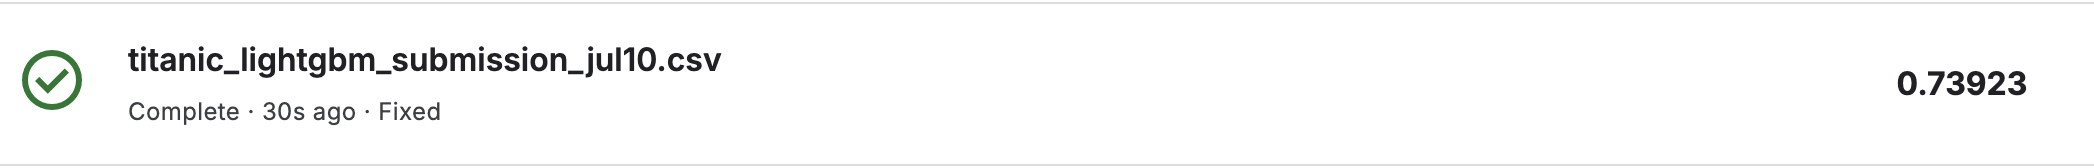
**A lazy RandomForest model from 2 years ago** - 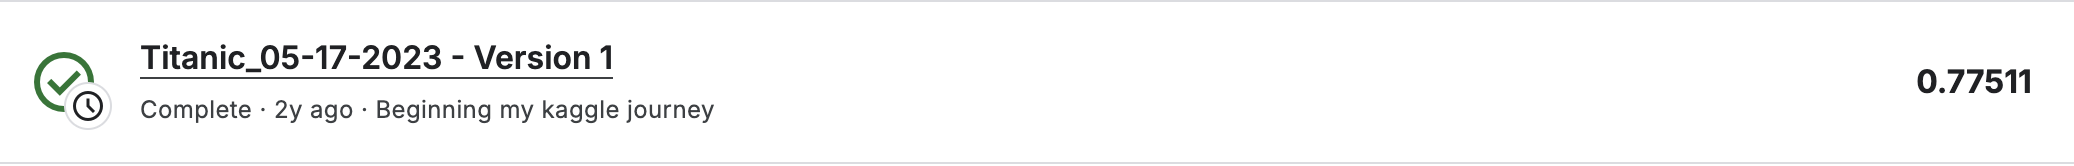


And here we go. My machine learning professor told our class this semester that his PHD student had written a paper that proved that a simple, 'stupid' baseline model had outperformed complex neural network on some task that I'm blanking out right now. With that our professor recommended to the whole class, "Do not underestimate the power of simple baselines. It may just surprise you".

I took that advice to heart immediately, always writing simple baselines, and even had a moment during the class's final project where I was faced with that hard truth again, when me and groupmate's simple recommender system beat my "fancier" versions.

Well... life has presented me with this truth again. 2 years ago, I had attempted this very challenge, and look at the scores... In the past, my model was a simple RandomForestClassifier that only used 4 out of the  9 features available. No feature engineering either. **That model has outperformed this model, that I spent nearly a month on...**

Phew. What I can say? I have much to learn ;)